In [1297]:
#install.packages("readxl")
library(tidyverse)
library(rvest)
library(readxl)
install.packages("reshape2")
library(reshape2)
library(scales)
install.packages("hrbrthemes")


library(hrbrthemes)

library(waffle)

options(repr.plot.width=15, repr.plot.height=15, repr.plot.pointsize=1000) # Setting plot size as a global option.

base_theme <- theme(plot.title=element_text(size=30), # Setting a default size for all text in our plots.
                    axis.title=element_text(size=30),
                    axis.text.x=element_text(size=15),
                    axis.text.y=element_text(size=15),
                    legend.title=element_text(size=25),
                    legend.text=element_text(size=20)) 





The downloaded binary packages are in
	/var/folders/xk/xq0cwh3n7fz7v_0827s1pq400000gn/T//RtmpmVRcLQ/downloaded_packages

The downloaded binary packages are in
	/var/folders/xk/xq0cwh3n7fz7v_0827s1pq400000gn/T//RtmpmVRcLQ/downloaded_packages


NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow



In [1097]:
#ignor waring
defaultW <- getOption("warn") 

options(warn = -1) 

In [1098]:
#first we get all xlsx file links from url
mental_health_data_urls_all_years <- 'https://www.health.govt.nz/our-work/mental-health-and-addiction/mental-health-and-addiction-monitoring-reporting-and-data' %>% 
                                        read_html() %>%
                                        html_element('#node-12245 > div > div > div > ul:nth-child(19)') %>%
                                        html_elements("a") %>%
                                        html_attrs() %>% 
                                        str_c('https://www.health.govt.nz/', .)
#function is to download xlsx from health url 
download_xlsx_file <- function(heath_url, file_name){
                        download_ur <- heath_url %>% 
                            read_html() %>%
                            html_element("#block-system-main > div > div:nth-child(2) > div.panel-panel.right.col-xs-12.col-sm-12.col-md-3.col-lg-3 > div.panel-pane.pane-views.pane-file-attachments-revisioning.pane-downloads-right.standard-block.even.hidden-xs.hidden-sm > div > div > div > div > ul > li > span > a") %>% 
                            html_attr("href") 
                        download.file(url = download_ur, destfile = file_name)
}


build_sheet_name <- function(str1, str2, separator){
    data <- paste(str1, str2, sep=separator)
    return(data)
}

get_sheet_separator <- function(file_name){
    sheets <- file_name %>% excel_sheets()
    if ('table1,2' %in% sheets){
        separator <- ','
    }else{
        separator <- '&'
    }
}


#iteral through every year from 2014 to 2019
file_metadata_df <- data.frame(year=double(),
                               file_name=character(),
                               url=character(),
                               separator=character())

start_year = 2020
counter = 0
for (url_yearly_health in mental_health_data_urls_all_years){
    file_name = str_c('mental_health', start_year) %>% 
                    str_c('.xlsx')
    url_to_download = url_yearly_health
    if (counter == 4){
        print(counter)
        url_to_download = 'https://www.health.govt.nz/publication/mental-health-and-addiction-service-use-2015-16'
    }
    download_xlsx_file(url_to_download, file_name)
    separator <- get_sheet_separator(file_name)
    file_metadata_df <- file_metadata_df %>% add_row(year=start_year,
                                                     file_name=file_name,
                                                     url=url_to_download,
                                                     separator=separator)
    start_year = start_year - 1
    counter= counter + 1

}
#we add some custom years to the list
file_metadata_df <- file_metadata_df %>% add_row(year=2011:2013, 
                                                 file_name=c('mental_health2011.xlsx', 'mental_health2012.xlsx', 'mental_health2013.xlsx'),
                                                 url=NA,
                                                 separator='&')

file_metadata_df

[1] 4


year,file_name,url,separator
<dbl>,<chr>,<chr>,<chr>
2020,mental_health2020.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2019-20-tables,","
2019,mental_health2019.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2018-19-tables,","
2018,mental_health2018.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2017-18-tables,","
2017,mental_health2017.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2016-17-tables,","
2016,mental_health2016.xlsx,https://www.health.govt.nz/publication/mental-health-and-addiction-service-use-2015-16,","
2015,mental_health2015.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2014-15,&
2014,mental_health2014.xlsx,https://www.health.govt.nz//publication/mental-health-and-addiction-service-use-2013-14,&
2011,mental_health2011.xlsx,NA,&
2012,mental_health2012.xlsx,NA,&


In [1099]:
#get all col names for table use after
#get metadata from one of the files.
first_file = file_metadata_df[1,]

age_group_col_names <-  first_file$file_name %>% read_excel(sheet = build_sheet_name('table1', '2', first_file$separator),
                                                            range = cell_rows(4:4)) %>% colnames()
add_sex_totl_age_group_col_names <- c('gender', "Total", age_group_col_names)


table_1_2_positions <- tibble(ethnic_group=c('Maori', 'Pacific', 'Asian', 'Other'),
                              range=c('B9:U10', 'B12:U13', 'B15:U16', 'B18:U19'))


In [1100]:
# 2010 File is different to every other file, so we need a different parser for it.

file_2010 <- "mental_health2010.xls"


get_2010_dfs <- function(file, sheet, range, target_gender, target_ethtnic_group, age_group){
    csv_file_read <- file %>% read_excel(sheet = sheet, range=range)
    colnames(csv_file_read) <- c('amount')
    csv_file_read <- csv_file_read %>% 
                     mutate(gender=target_gender, ethnic_group= target_ethtnic_group) %>% 
                     cbind(age_group)
    return(csv_file_read)
}

client_ages_group_2010 <- file_2010 %>% read_excel(sheet = "T7 Nos Rates 0910 EthSexAge",  range='A4:A22') 
colnames(client_ages_group_2010) <- c('age_group')

data_2010_clients <- get_2010_dfs(file_2010, "T7 Nos Rates 0910 EthSexAge", 'B4:B22', 'Male', 'Maori', client_ages_group_2010 ) %>% 
                        rbind(get_2010_dfs(file_2010, "T7 Nos Rates 0910 EthSexAge", 'D4:D22', 'Female', 'Maori', client_ages_group_2010 )) %>% 
                        rbind(get_2010_dfs(file_2010, "T7 Nos Rates 0910 EthSexAge", 'H4:H22', 'Male', 'Unknown', client_ages_group_2010 )) %>% 
                        rbind(get_2010_dfs(file_2010, "T7 Nos Rates 0910 EthSexAge", 'H4:H22', 'Female', 'Unknown', client_ages_group_2010 )) %>% 
                        mutate('year'=2010)


New names:
* `` -> ...1



In [1299]:
#two different way get first table of total group data

clients_by_age_ethnic_group_df <- data.frame(year=double(),
                                         gender=character(), 
                                         ethnic_group=character(),
                                         age_group=character(),
                                         amount=integer() 
                                         ) 


get_clients_by_gender_ethnic_group <- function(file_metadata, columns){

    clients_by_age_ethnic_group <- data.frame(year=double(),
                                         gender=character(), 
                                         ethnic_group=character(),
                                         age_group=character(),
                                         amount=integer()) 
    
    for (i in 1:nrow(table_1_2_positions)) {
        row <- table_1_2_positions[i,]
        range = row$range
        if (file_metadata$year == '2011'){
            sheet <- 'Table1'
        }else if(file_metadata$year == '2012'){
            sheet <- 'table1'
        } else if (file_metadata$year == '2016'){
            if (range == 'B9:U10'){
                range = 'B8:U9'
            }
            else if (range=='B12:U13'){
                range = 'B11:U12'
            }
            else if (range=='B15:U16'){
                range='B14:U15'
            }else{
                range = 'B17:U18'
            }
           
            sheet <- build_sheet_name("table1", "2", file_metadata$separator)
        }else{
            sheet <- build_sheet_name("table1", "2", file_metadata$separator)
           
        }
        ethnic_group_df <- file_metadata$file_name %>% read_excel(sheet=sheet,
                                                       range = range,
                                                       col_names = add_sex_totl_age_group_col_names) #range = cell_rows(3:19), 
        ethnic_group_df <- ethnic_group_df %>% add_column(ethnic_group=row$ethnic_group, year=file_metadata$year)
        ethnic_group_df <- ethnic_group_df %>% select(-Total)
        long_col_name <- ethnic_group_df %>% select(ends_with("-"), ends_with('+')) %>% names()
        clients_by_age_ethnic_group <- clients_by_age_ethnic_group %>% 
                                       add_row(ethnic_group_df %>% 
                                       gather(age_group, amount, long_col_name, factor_key=TRUE))
    }  
    return(clients_by_age_ethnic_group)
}

get_all_year_clients_by_gender_ethnic_group <- function(){
    for (i in 1:nrow(file_metadata_df )){
        row <- file_metadata_df[i,]
        clients_by_age_ethnic_group_df <- clients_by_age_ethnic_group_df %>% add_row(get_clients_by_gender_ethnic_group(row, add_sex_totl_age_group_col_names))
    }
    return(clients_by_age_ethnic_group_df) 
    
}



In [1300]:
full_clients_by_gender_ethnic_df <- get_all_year_clients_by_gender_ethnic_group()

In [1411]:
# lets get the years outside of the norm
#make all df 2002-2007 data tidy

get_df_tidy <- function(df, year_num){
    #get num of row
    n_row_age_sheeta1 <- nrow(df)
    #set all na values with activity type 
    for (row_num in 1:n_row_age_sheeta1){
        if(df$ethnic_group[[row_num]] %>% is.na()){
            df$ethnic_group[[row_num]] = df$ethnic_group[[row_num - 1]]
        }
    }
    result <- df %>% 
                filter(gender!='NA') %>% 
                gather(age_group, amount, -c(ethnic_group,gender,amount)) %>% 
                mutate('year'=year_num) 
    result <- result %>% filter(gender!='Total') %>% filter(ethnic_group!='Total')
    result <- result[,c(5,2,1,3,4)]
    return(result)
}

#get 2002/2005 data

file_metadata_2001_2007 <- tibble(year=2002:2008,
                                  sheet=c('A1', 'A1', 'A1', 'A1', '1A', '1B', 'A1'),
                                  range=c('A5:U25', 'A4:U24', 'A5:U26', 'A5:U25', 'A5:U26', 'A5:U26', 'A5:U25'),
                                  titles=c('D5:U5', 'D4:U4', 'D5:U5', 'D5:U5', 'D5:U5', 'D5:U5', 'D5:U25')
                                 )

get_2001_2007_file_df <- function(file_name, year_num){
    print(year_num)
    file_metadata <- file_metadata_2001_2007 %>% filter(year==year_num)
    #get client age group names
    client_ages_sheeta1 <- file_name %>% read_excel(sheet = file_metadata$sheet, range=file_metadata$titles) %>% colnames()
    col_names_seen_by_age_sheeta1  <- c('ethnic_group', 'gender', 'amount', client_ages_sheeta1)
    
    #get data from the file rename with names before
    client_seen_by_age_data_a1 <-  file_name %>% read_excel(sheet=file_metadata$sheet, range=file_metadata$range)
    colnames(client_seen_by_age_data_a1) <- col_names_seen_by_age_sheeta1 

    return(get_df_tidy(client_seen_by_age_data_a1, year_num))
}

get_all_a1sheet_2002_2007_df <- function(){
    
    result <- get_2001_2007_file_df('mental_health2002.xls',2002) %>% 
             rbind(get_2001_2007_file_df('mental_health2003.xls',2003)) %>% 
             rbind(get_2001_2007_file_df('mental_health2004.xls',2004)) %>% 
             rbind(get_2001_2007_file_df('mental_health2005.xls',2005)) %>% 
             rbind(get_2001_2007_file_df('mental_health2006.xls',2006)) %>% 
             rbind(get_2001_2007_file_df('mental_health2007.xls',2007)) %>% 
             rbind(get_2001_2007_file_df('mental_health2008.xls',2008)) 


    return(result)
}

#year from 2002-2007, 2010-2019
full_clients_by_gender_ethnic_df <- full_clients_by_gender_ethnic_df %>% 
                                    rbind(get_all_a1sheet_2002_2007_df()) %>%  
                                    rbind(data_2010_clients) %>%
                                    arrange(year) %>% 
                                    filter(gender!='Total') %>%
                                    filter(ethnic_group!='Total') 


[1] 2002


New names:
* `` -> ...1
* `` -> ...2



[1] 2003


New names:
* `` -> ...1
* `` -> ...2



[1] 2004


New names:
* `` -> ...1
* `` -> ...2



[1] 2005


New names:
* `` -> ...1
* `` -> ...2



[1] 2006


New names:
* `` -> ...1
* `` -> ...2



[1] 2007


New names:
* `` -> ...1
* `` -> ...2



[1] 2008


New names:
* `` -> ...1
* `` -> ...2



In [1302]:
#full_clients_by_gender_ethnic_df <- full_clients_by_gender_ethnic_df %>% rbind(get_2001_2007_file_df('mental_health2006.xls',2006))

In [1417]:
#lets clean this dataframe a littleMaori
full_clients_by_gender_ethnic_df <- full_clients_by_gender_ethnic_df %>% mutate(ethnic_group=gsub("Maori", "Māori", ethnic_group),
                                                                                age_group=gsub('-', '–', age_group))


year,gender,ethnic_group,5–,10–,15–,20–,25–,30–,35–,⋯,55–59,60–64,65–69,70–74,75–79,80–84,0–,0–4,45–,55–
<dbl>,<chr>,<chr>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,⋯,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>
2002,Male,Asian,5,23,54,87,87,73,78,⋯,15,17,10,8,9,5,NULL,NULL,NULL,NULL
2002,Female,Asian,3,13,37,118,87,104,130,⋯,33,22,25,21,11,2,NULL,NULL,NULL,NULL
2002,Male,Māori,69,549,951,954,1009,1091,1189,⋯,123,73,41,33,20,7,NULL,NULL,NULL,NULL
2002,Female,Māori,49,184,577,934,753,892,1005,⋯,139,96,70,43,27,21,NULL,NULL,NULL,NULL
2002,Male,Other,348,2174,3244,2924,2537,3021,3534,⋯,1206,896,609,578,554,473,NULL,NULL,NULL,NULL
2002,Female,Other,175,924,1777,3228,2336,2865,3628,⋯,1461,1072,813,769,927,887,NULL,NULL,NULL,NULL
2002,Male,Pacific,10,63,103,171,216,217,192,⋯,28,20,17,9,8,5,NULL,NULL,NULL,NULL
2002,Female,Pacific,2,19,78,153,135,128,151,⋯,44,32,18,12,11,9,NULL,NULL,NULL,NULL
2003,Male,Asian,4,30,62,83,122,88,80,⋯,20,22,20,16,4,6,NULL,NULL,NULL,NULL


Saving 21 x 21 in image



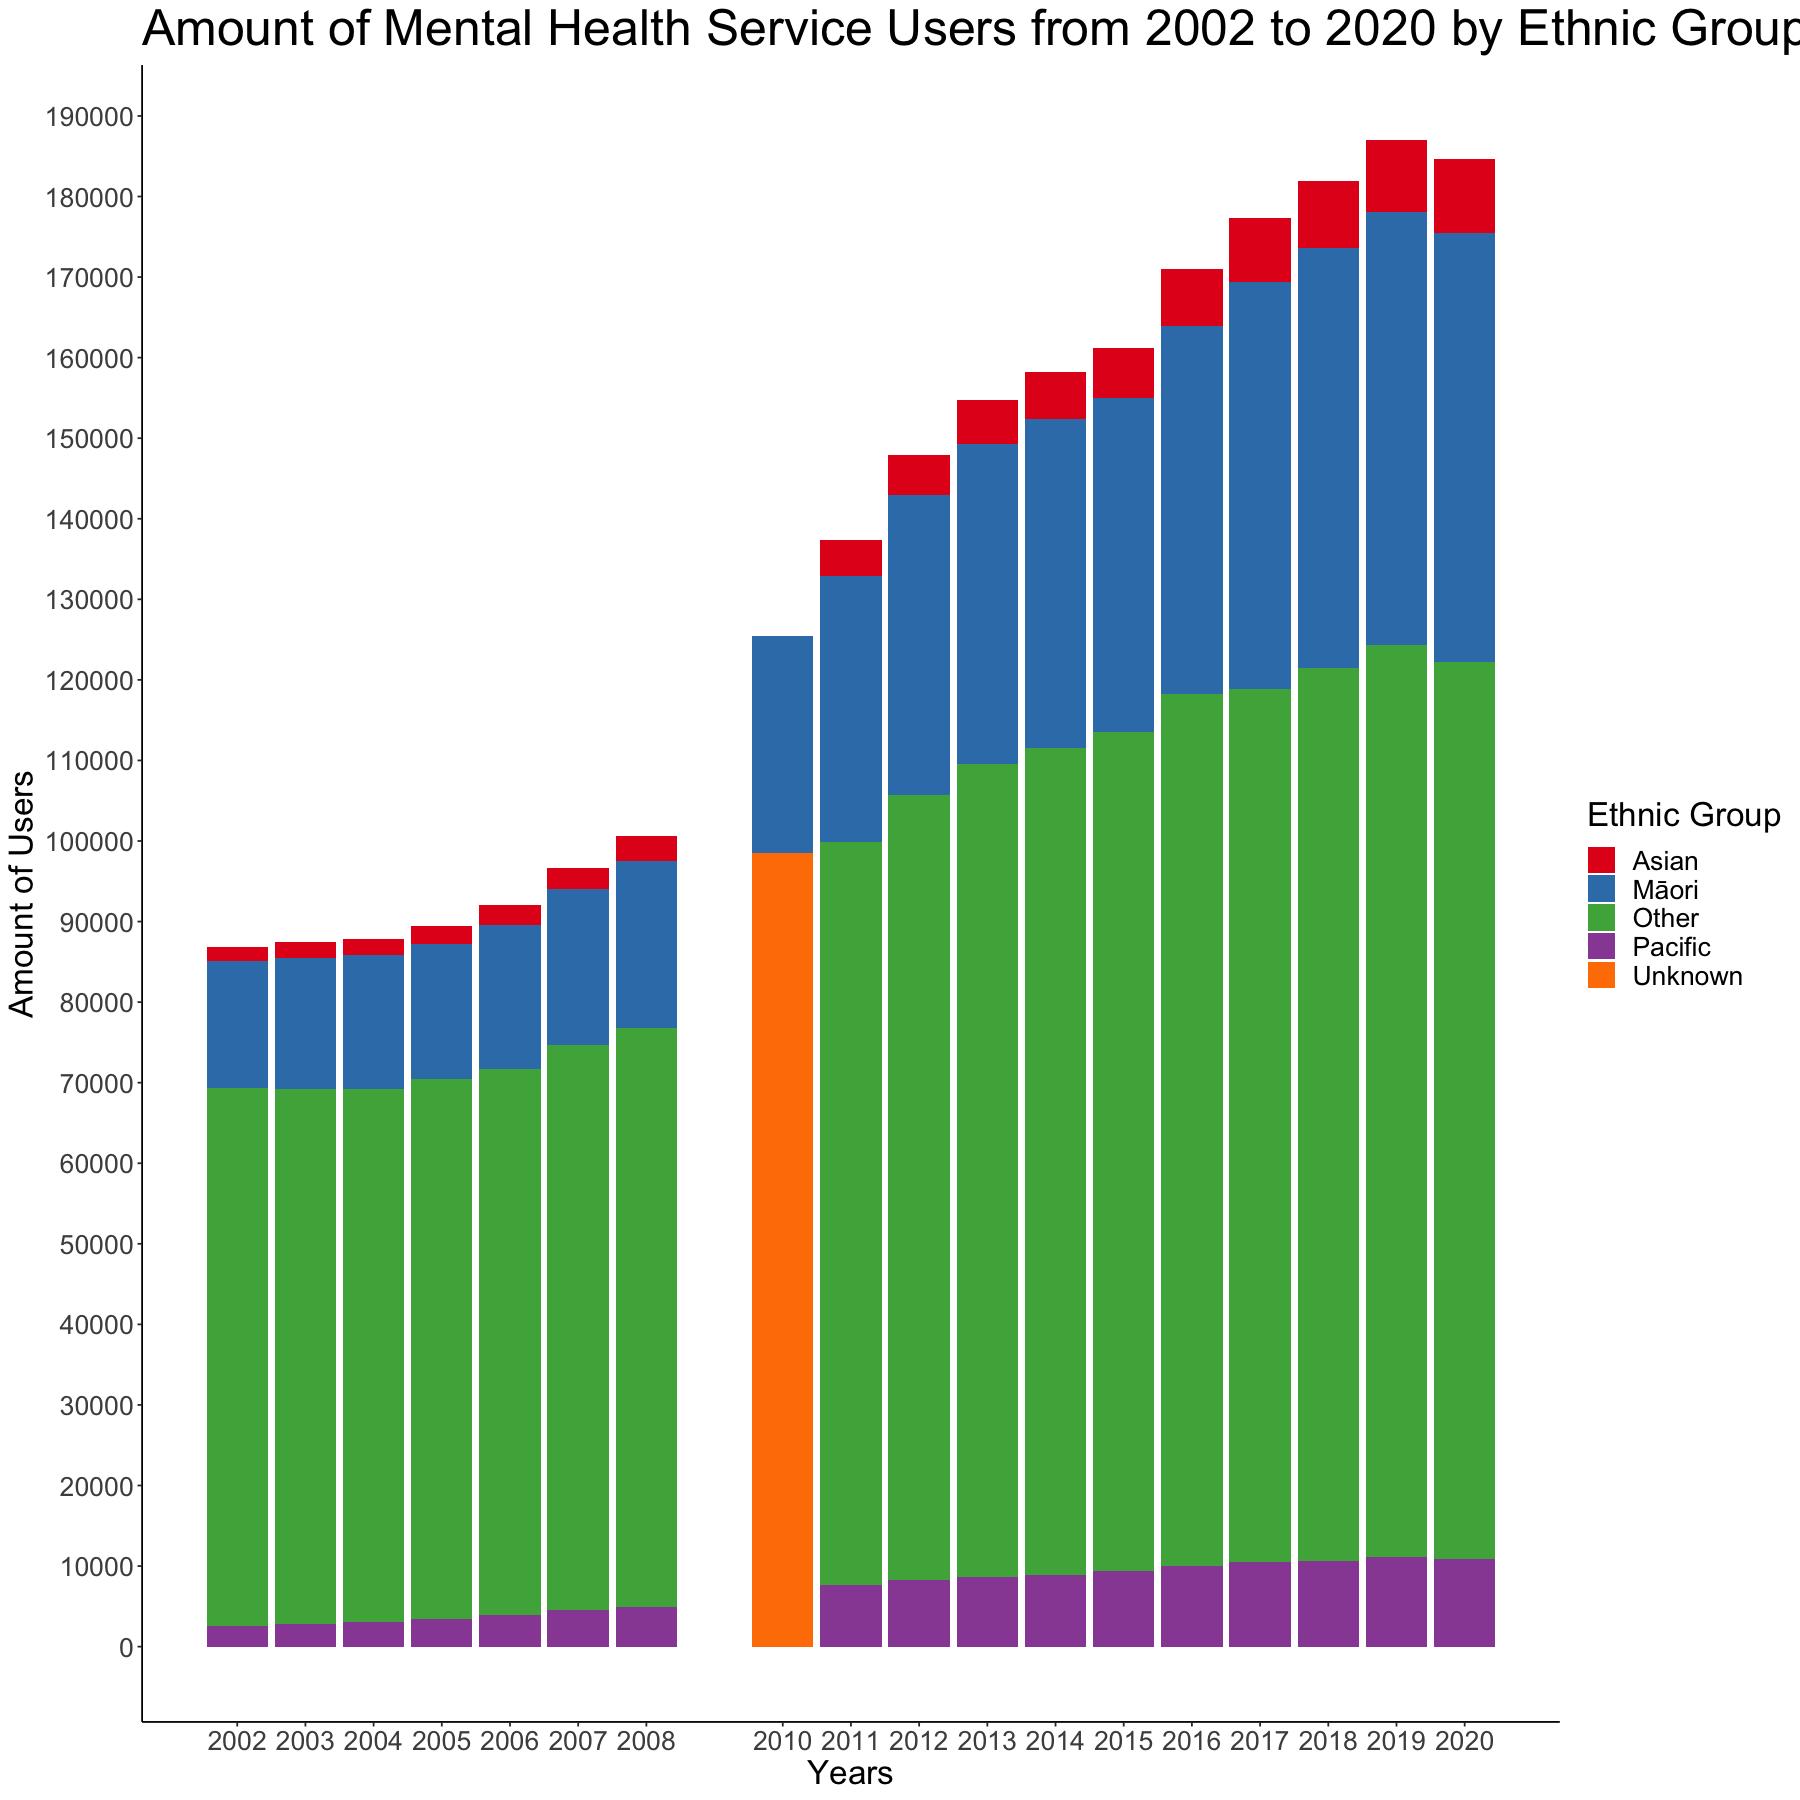

In [1386]:
years <- full_clients_by_gender_ethnic_df %>% select(year) %>% distinct()
full_clients_by_gender_ethnic_df %>% #filter(gender=='Male') %>%
                                     group_by(year, ethnic_group) %>% 
                                     select(year, ethnic_group, amount) %>%
                                     summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                                     ggplot( aes(fill=ethnic_group, y=sum_amount, x=year)) + 
                                     geom_bar(position="stack", stat="identity") + 
                                     scale_x_continuous(breaks=years$year) + 
                                     labs(x= "Years", 
                                          y='Amount of Users',
                                          fill='Ethnic Group',
                                          title='Amount of Mental Health Service Users from 2002 to 2020 by Ethnic Group') +
                                     theme_classic() + theme(plot.title = element_text(size=30),
                                                            text = element_text(size=20))  +
                                     scale_fill_brewer(palette="Set1") +  #assigning pallete
                                     scale_y_continuous(breaks=seq(0, 2000000, 10000))
ggsave('amount_ouf_users.png', scale=3)

Saving 21 x 21 in image



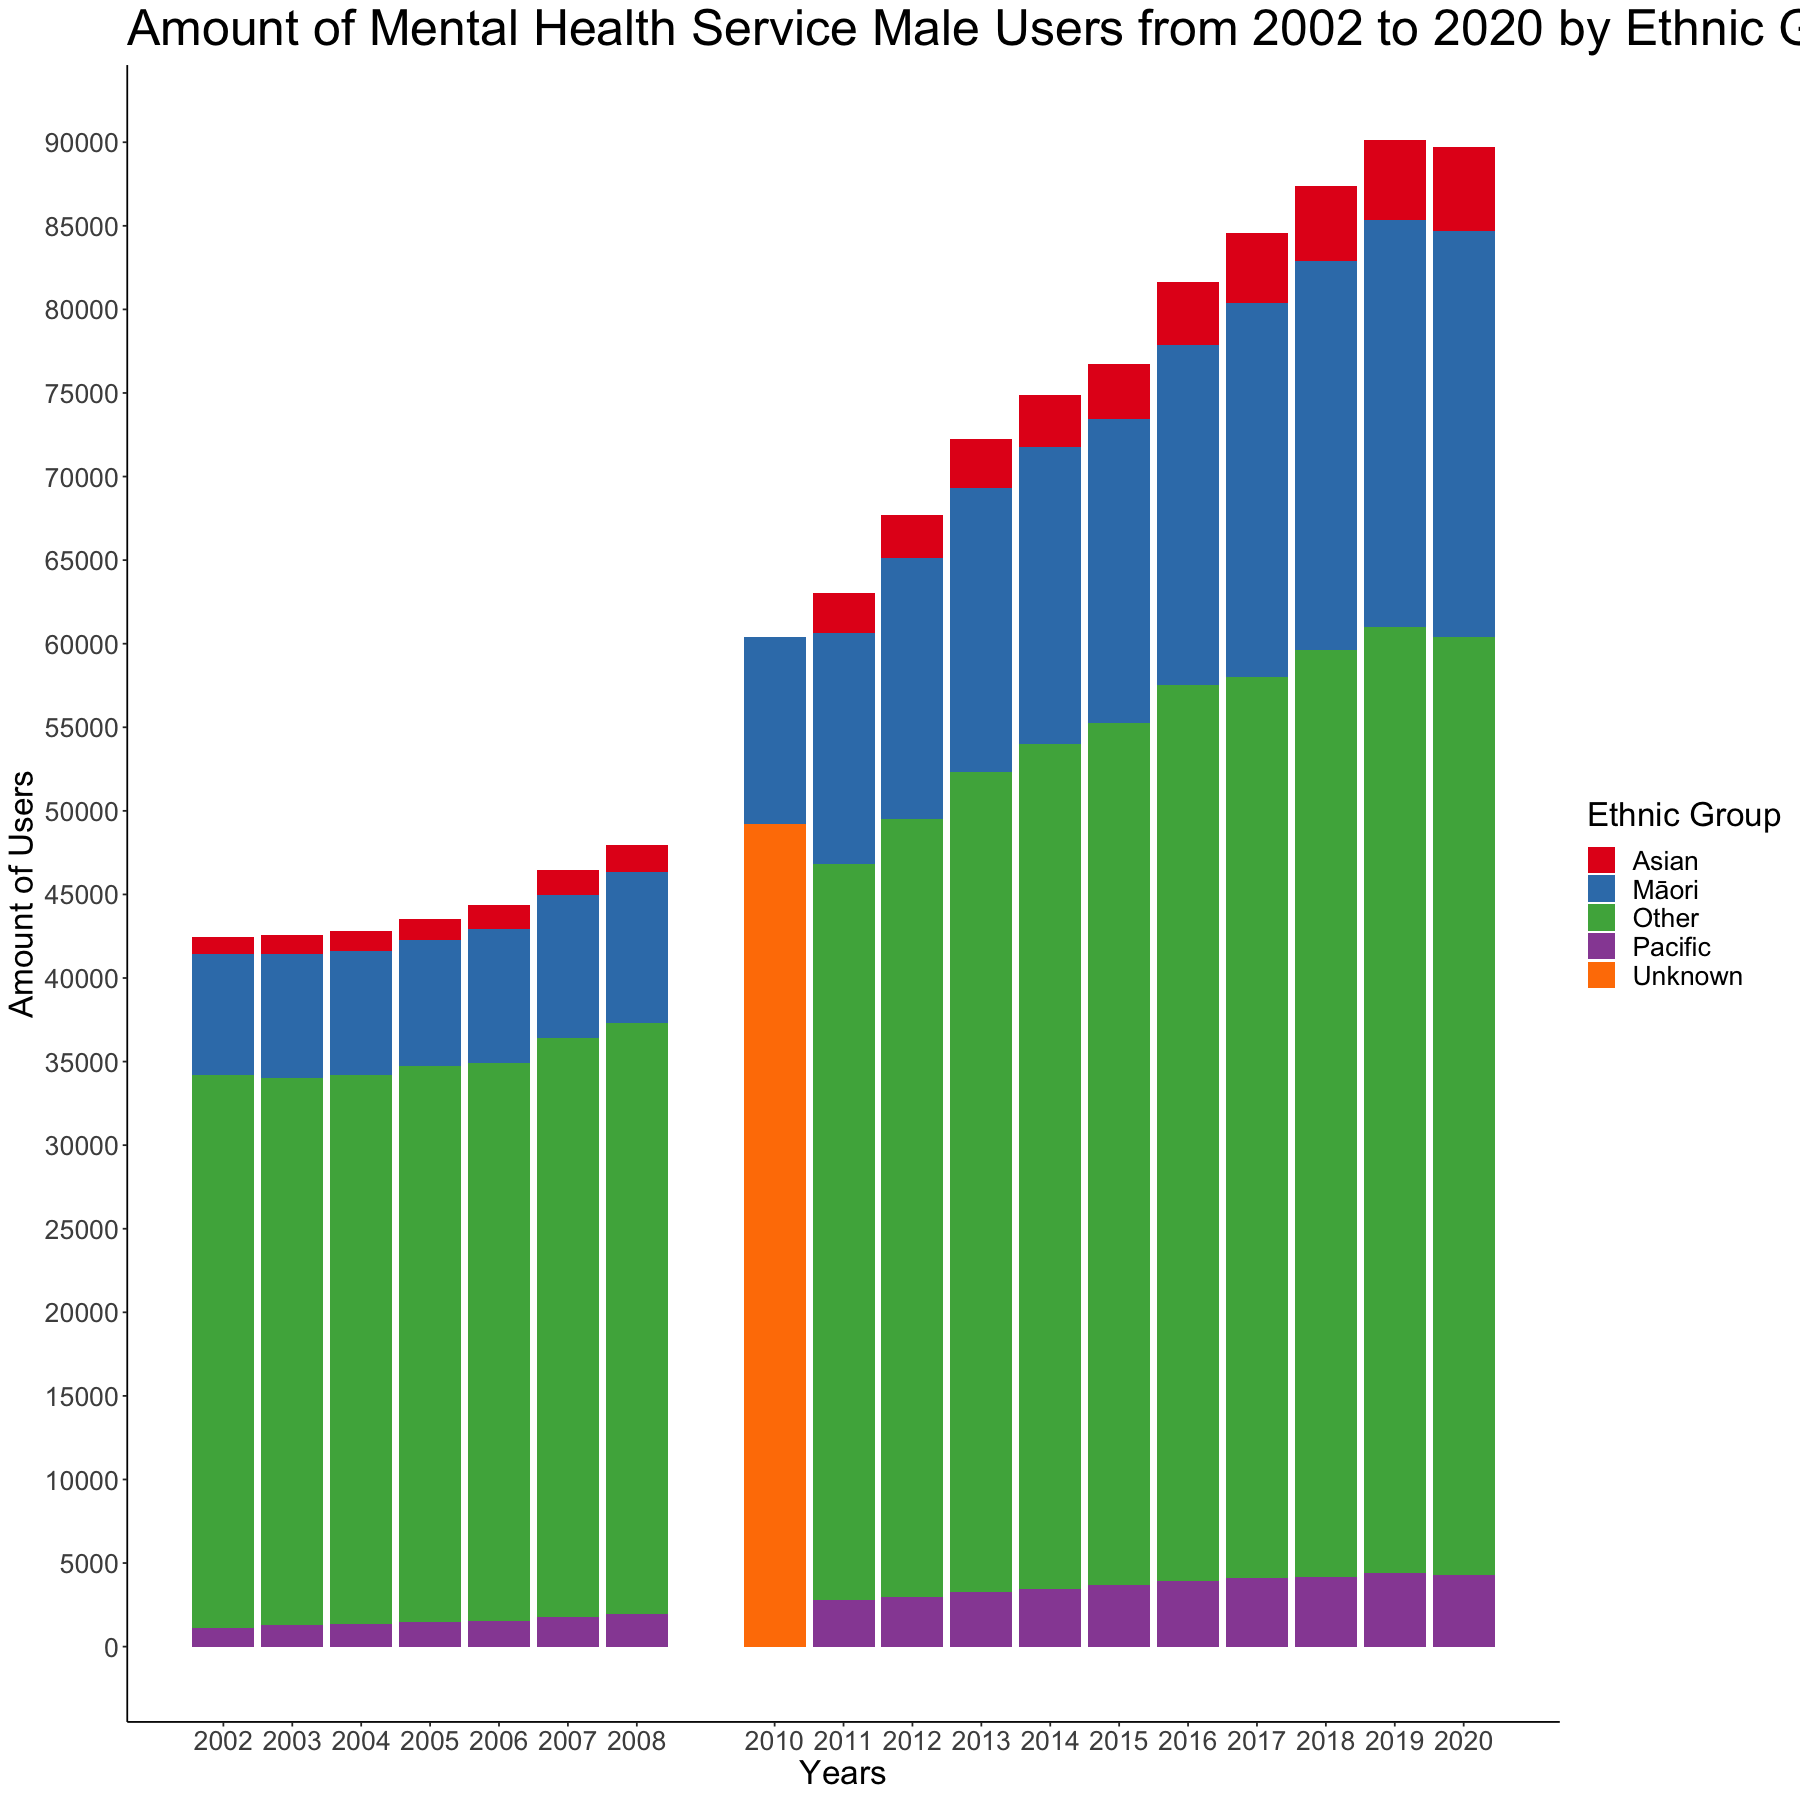

In [1391]:
full_clients_by_gender_ethnic_df %>% filter(gender=='Female') %>%
                                     group_by(year, ethnic_group) %>% 
                                     select(year, ethnic_group, amount) %>%
                                     summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                                     ggplot( aes(fill=ethnic_group, y=sum_amount, x=year)) + 
                                     geom_bar(position="stack", stat="identity") + 
                                     scale_x_continuous(breaks=years$year) + 
                                     labs(x= "Years", 
                                          y='Amount of Users',
                                          fill='Ethnic Group',
                                          title='Amount of Mental Health Service Male Users from 2002 to 2020 by Ethnic Group') +
                                     theme_classic() + theme(plot.title = element_text(size=30),
                                                            text = element_text(size=20))  +
                                     scale_fill_brewer(palette="Set1") +  #assigning pallete
                                     scale_y_continuous(breaks=seq(0, 200000, 5000))
ggsave('amount_ouf_female_users.png', scale=3)

Saving 21 x 21 in image



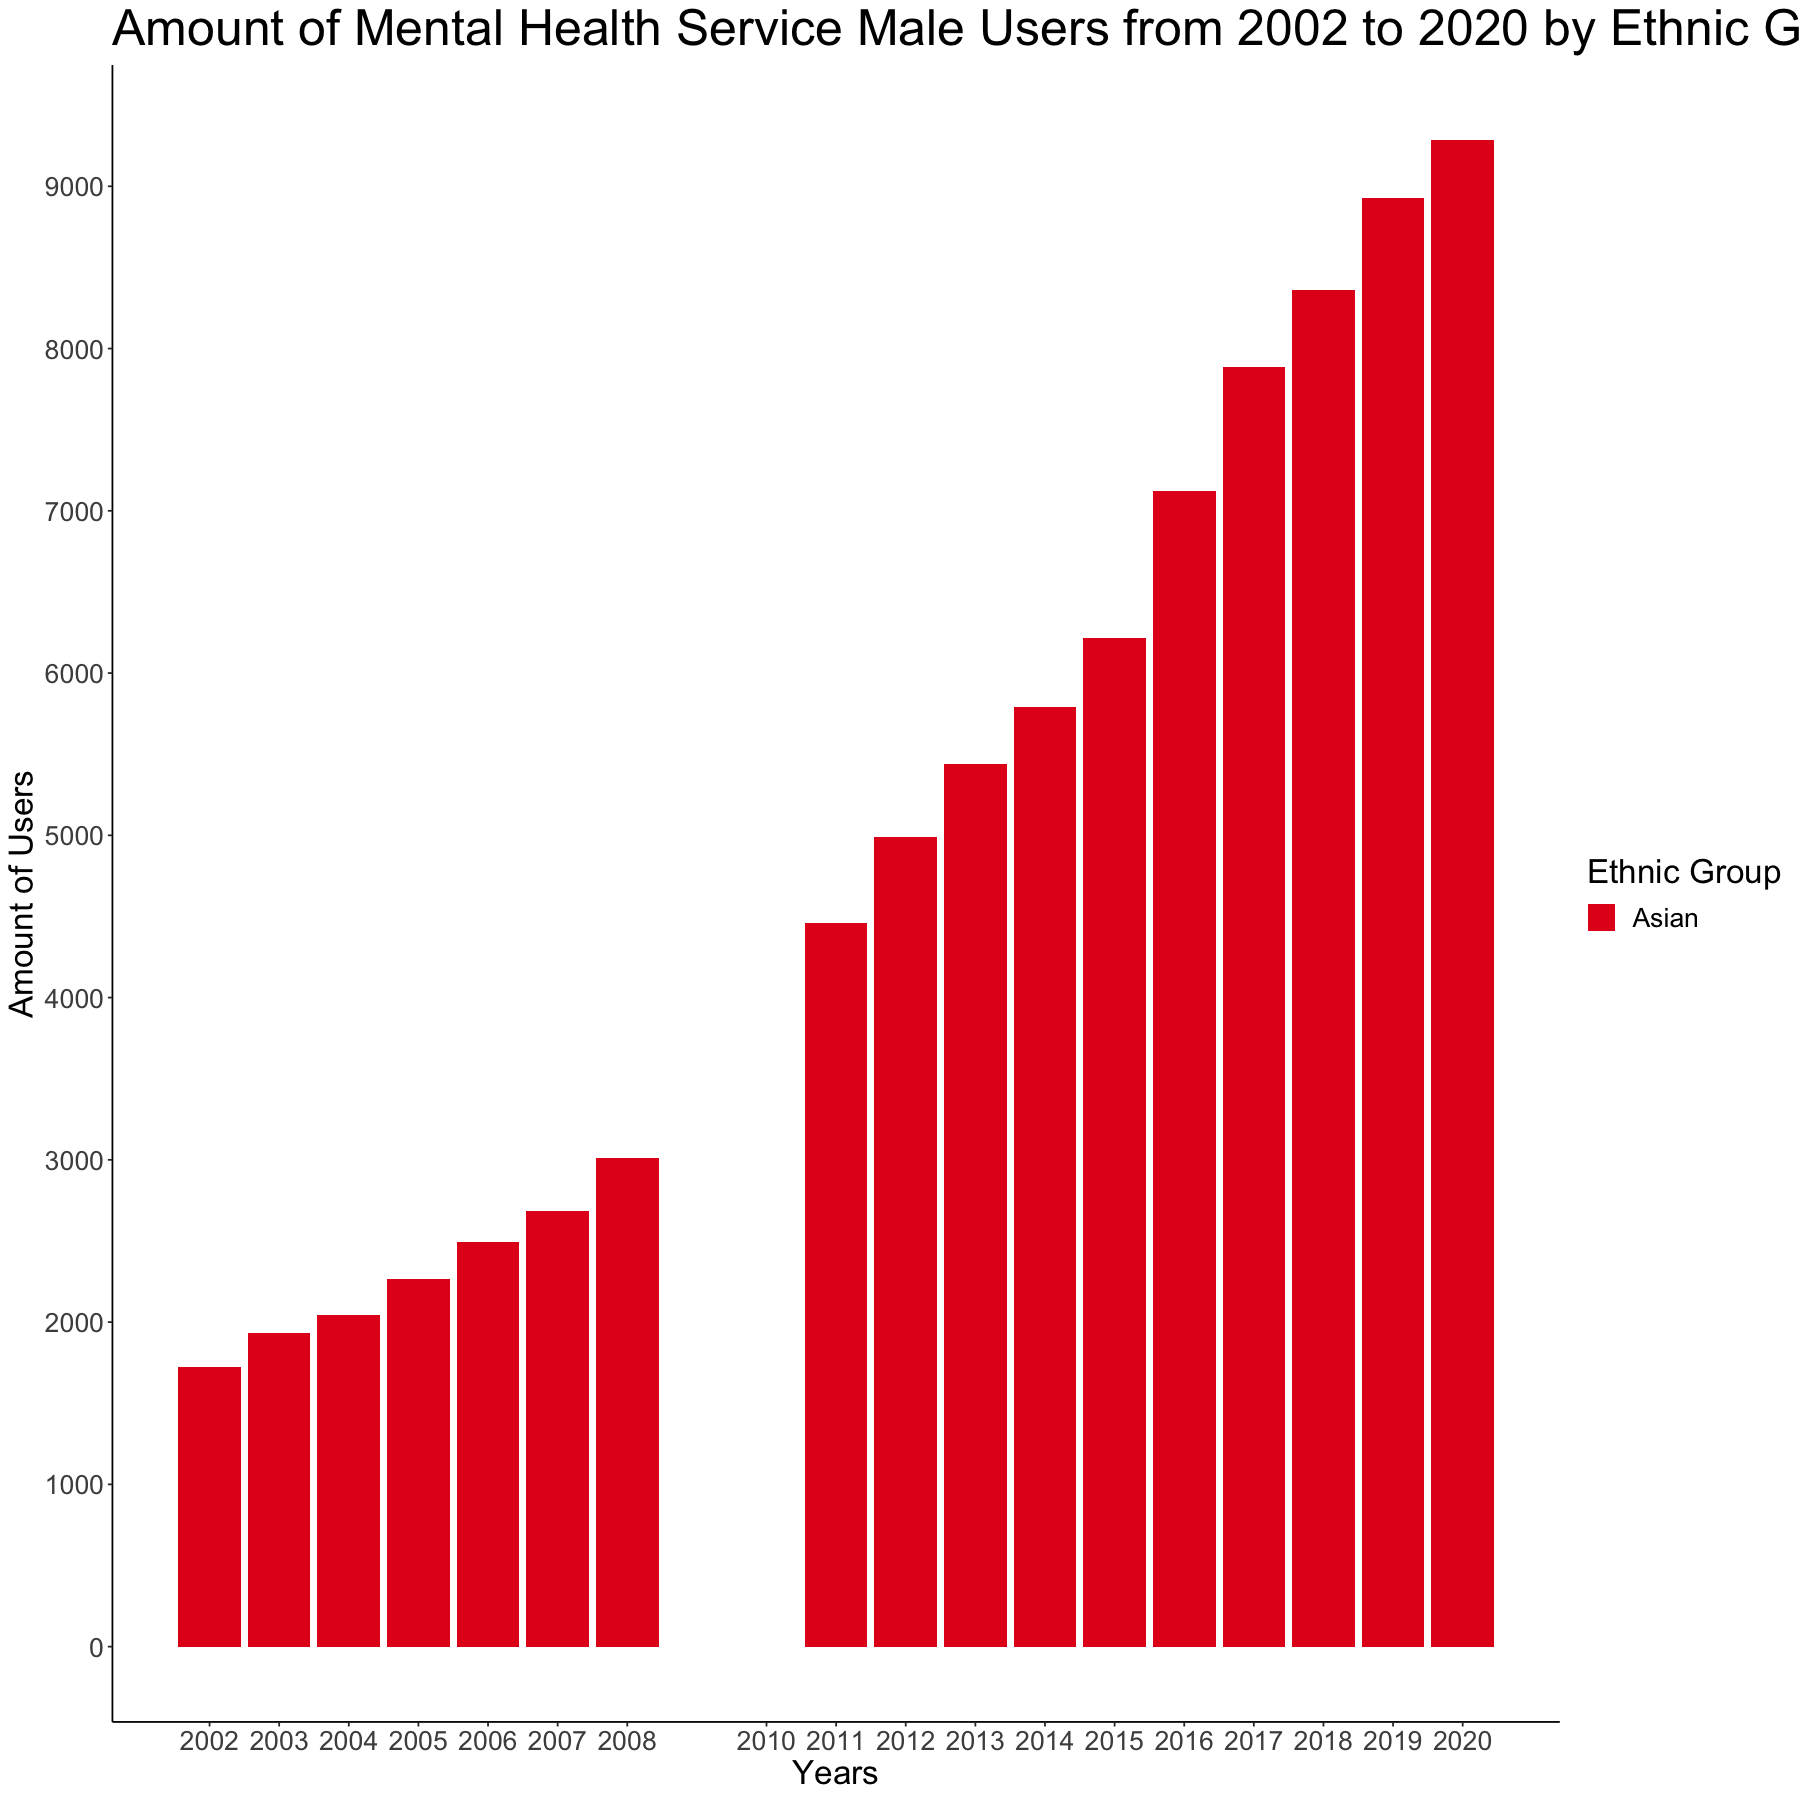

In [1390]:
full_clients_by_gender_ethnic_df %>% filter(ethnic_group=="Asian") %>%
                                     group_by(year, ethnic_group) %>% 
                                     select(year, ethnic_group, amount) %>%
                                     summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                                     ggplot( aes(fill=ethnic_group, y=sum_amount, x=year)) + 
                                     geom_bar(position="stack", stat="identity") + 
                                     scale_x_continuous(breaks=years$year) + 
                                     labs(x= "Years", 
                                          y='Amount of Users',
                                          fill='Ethnic Group',
                                          title='Amount of Mental Health Service Male Users from 2002 to 2020 by Ethnic Group') +
                                     theme_classic() + theme(plot.title = element_text(size=30),
                                                            text = element_text(size=20))  +
                                     scale_fill_brewer(palette="Set1") +  #assigning pallete
                                     scale_y_continuous(breaks=seq(0, 20000, 1000))

ggsave('amount_ouf_asian_users.png', scale=3)

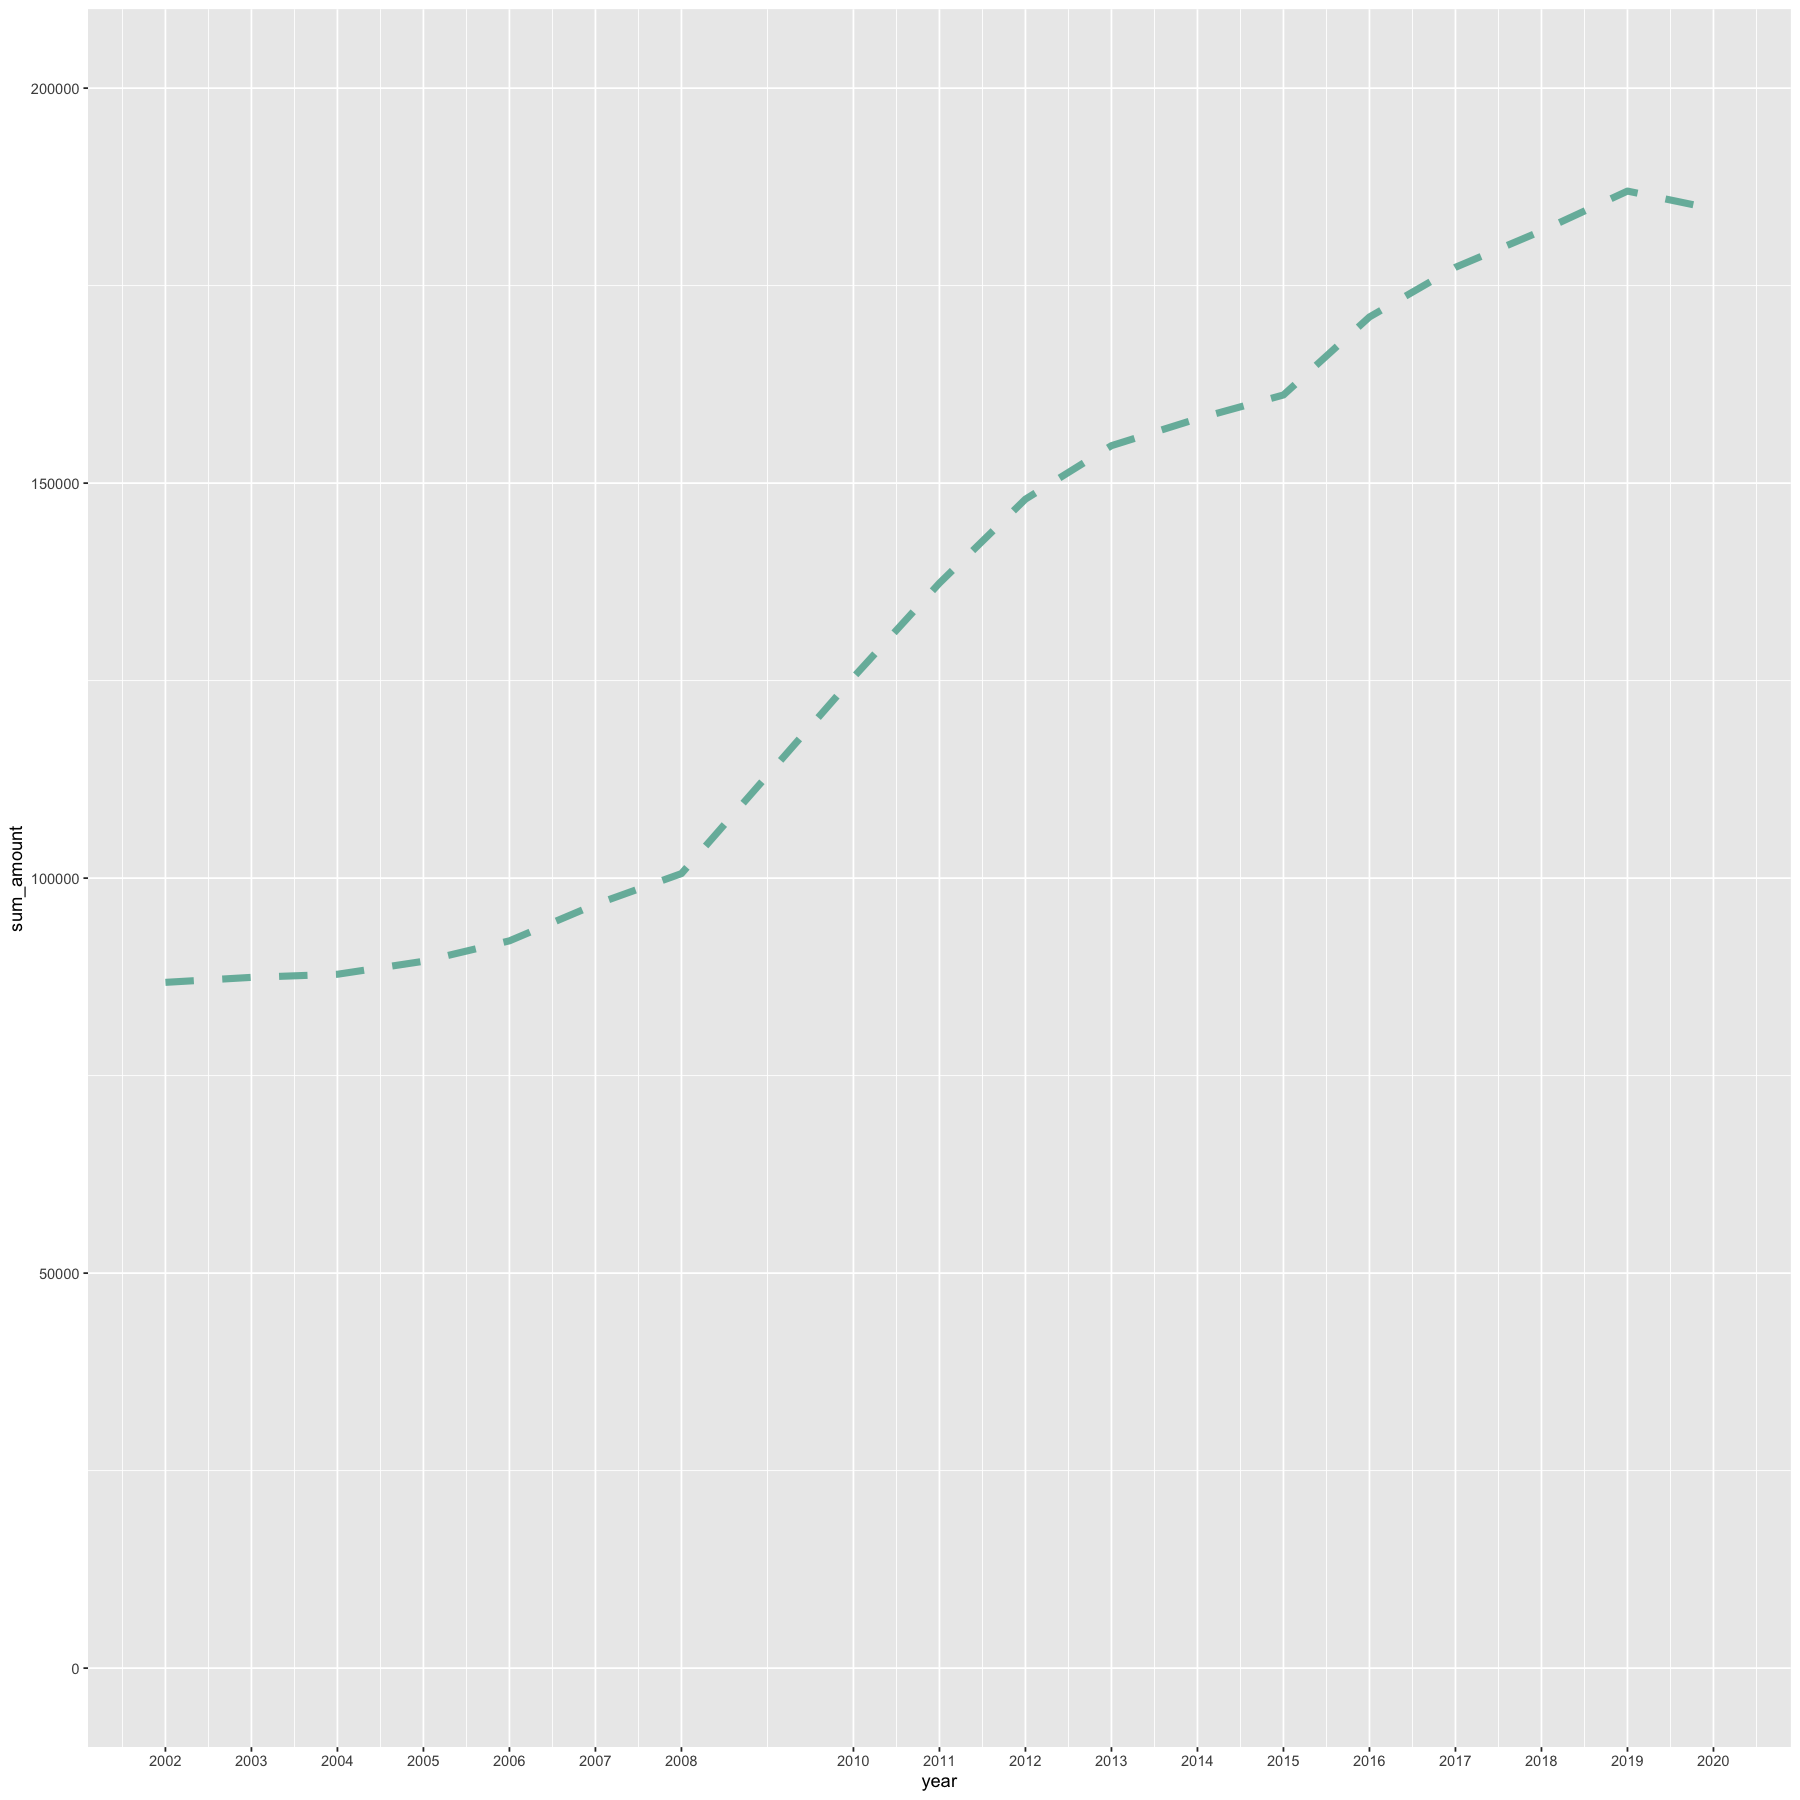

In [1243]:
full_clients_by_gender_ethnic_df %>% group_by(year) %>% 
                                     select(year, amount) %>%
                                     summarise(sum_amount = sum(amount))  %>%
                                     ggplot(aes(x=year, y=sum_amount)) +
                                     scale_x_continuous(breaks=years$year) + 
                                     scale_y_continuous(limits=c(0, 200000)) + 
                                     geom_line(color="#69b3a2", size=2, alpha=0.9, linetype=2)


In [1435]:
full_clients_by_gender_ethnic_df <- full_clients_by_gender_ethnic_df %>% mutate(age_group=gsub("0–4","0–", age_group)) %>%  
                                     mutate(age_group=gsub("0–5", "5–", age_group)) %>%  
                                     mutate(age_group=gsub("5–9", "10–", age_group)) %>%  
                                     mutate(age_group=gsub("10–14", "15–", age_group)) %>%  
                                     mutate(age_group=gsub("15–19", "20–", age_group)) %>%  
                                     mutate(age_group=gsub("20–24", "25–", age_group)) %>%  
                                     mutate(age_group=gsub("25–29", "30–", age_group)) %>%  
                                     mutate(age_group=gsub("30–34", "35–", age_group)) %>%  
                                     mutate(age_group=gsub("35–39", "40–", age_group)) %>%  
                                     mutate(age_group=gsub("40–44", "45–", age_group)) %>%  
                                     mutate(age_group=gsub("45–49", "50–", age_group)) %>%  
                                     mutate(age_group=gsub("50–54", "55–", age_group)) %>%  
                                     mutate(age_group=gsub("55–59", "60–",  age_group)) %>%  
                                     mutate(age_group=gsub("60–64", "65–", age_group)) %>%  
                                     mutate(age_group=gsub("65–69", "70–",  age_group)) %>%  
                                     mutate(age_group=gsub("70–74", "75–", age_group)) %>%  
                                     mutate(age_group=gsub("75–79", "80–",  age_group)) %>%  
                                     mutate(age_group=gsub("80–84", "85+", age_group)) %>%
                                     mutate(age_group=gsub("55–4", "60–", age_group)) %>% 
                                     mutate(age_group=gsub("-", "–", age_group))
full_clients_by_gender_ethnic_df %>% pivot_wider(names_from=age_group, values_from=amount) %>% filter(year==2007)


year,gender,ethnic_group,5–,10–,15–,20–,25–,30–,35–,⋯,50–,60–,65–,70–,75–,80–,85+,0–,45–,55–
<dbl>,<chr>,<chr>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,⋯,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>,<list>
2007,Male,Asian,"57, 57","77, 77","155, 155","147, 147","151, 151","104, 104","107, 107",⋯,"71, 71","18, 18","22, 22","28, 28","12, 12","5, 5","2, 2","7, 7","97, 97","50, 50"
2007,Female,Asian,"21, 21","63, 63","180, 180","170, 170","143, 143","153, 153","170, 170",⋯,"106, 106","35, 35","38, 38","29, 29","16, 16","11, 11","7, 7","9, 9","116, 116","81, 81"
2007,Male,Māori,"512, 512","997, 997","1497, 1497","1231, 1231","1258, 1258","1244, 1244","1303, 1303",⋯,"417, 417","106, 106","74, 74","44, 44","29, 29","16, 16","11, 11","56, 56","691, 691","209, 209"
2007,Female,Māori,"173, 173","615, 615","1302, 1302","923, 923","915, 915","984, 984","1070, 1070",⋯,"403, 403","139, 139","97, 97","63, 63","39, 39","30, 30","17, 17","29, 29","659, 659","213, 213"
2007,Male,Other,"1693, 1693","2927, 2927","3599, 3599","2911, 2911","2731, 2731","3302, 3302","3716, 3716",⋯,"2213, 2213","1070, 1070","742, 742","582, 582","647, 647","576, 576","517, 517","146, 146","3122, 3122","1574, 1574"
2007,Female,Other,"693, 693","1858, 1858","4201, 4201","2627, 2627","2536, 2536","3191, 3191","3545, 3545",⋯,"2134, 2134","1288, 1288","958, 958","775, 775","901, 901","1003, 1003","1099, 1099","80, 80","2881, 2881","1633, 1633"
2007,Male,Pacific,"100, 100","169, 169","379, 379","393, 393","357, 357","350, 350","312, 312",⋯,"92, 92","38, 38","31, 31","20, 20","15, 15","18, 18","3, 3","17, 17","163, 163","69, 69"
2007,Female,Pacific,"19, 19","117, 117","261, 261","194, 194","202, 202","191, 191","218, 218",⋯,"76, 76","47, 47","38, 38","30, 30","17, 17","10, 10","13, 13","16, 16","127, 127","53, 53"


Saving 21 x 21 in image



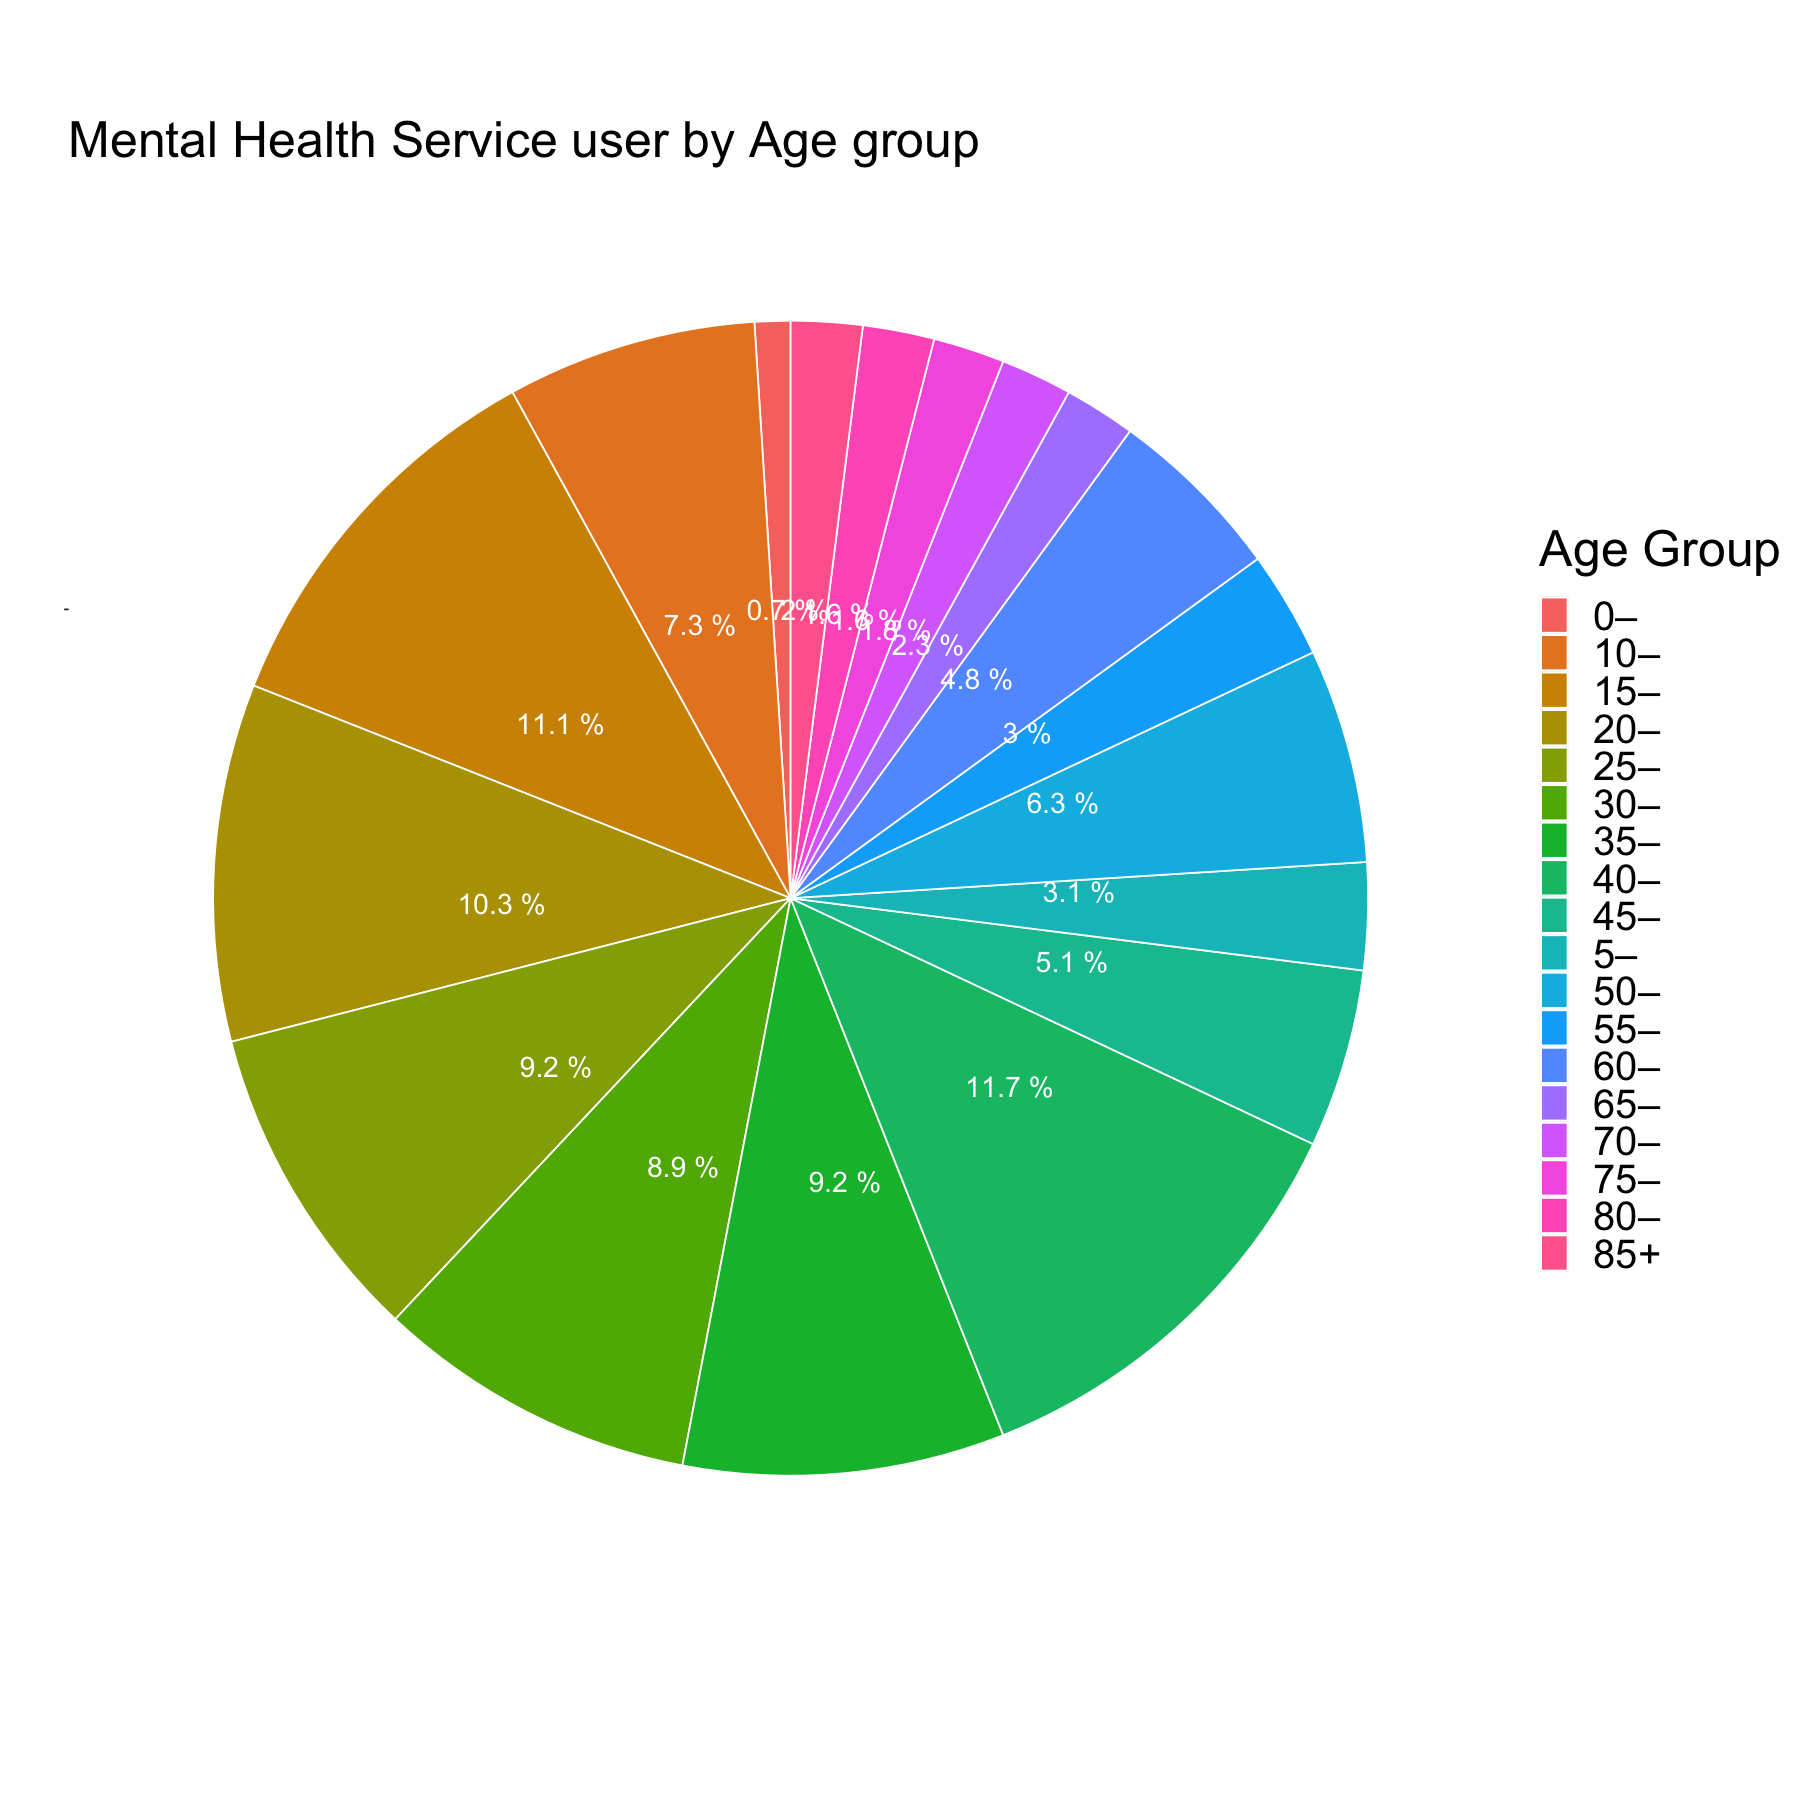

In [1444]:

full_clients_by_gender_ethnic_df %>% group_by(age_group) %>% 
                                     select(age_group, amount) %>%
                                     arrange(age_group) %>%
                                     summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                                     ggplot( aes(x='', fill=age_group, 
                                                 y=round(sum_amount/sum(sum_amount)*100))) + 
                                     geom_bar(stat="identity",
                                              color='white') + 
                                     geom_text(aes(x=1,
                                                  y=sum_amount/sum(sum_amount)*100, # calculating values for labels on every slice of the pie.
                                                  label=paste(ifelse(round(sum_amount/sum(sum_amount)*100, digits=1) > 0,
                                                               round(sum_amount/sum(sum_amount)*100, digits=1), 
                                                                ),'%')),
                                              color='white', #setting color
                                              size=6,
                                              position = position_stack(vjust = 0.4)) +#setting the colors and stat for the piechart
                                     coord_polar(theta="y") + 
                                     labs(x= "", 
                                          y="",
                                          fill='Age Group',
                                          title='Mental Health Service user by Age group') +


                                       theme(plot.title = element_text(size=30),
                                                            text = element_text(size=30),
                                                                     axis.text = element_text(size = 0),
                                                              panel.background = element_rect(fill = "white")
)
ggsave('age_groups.png', scale=3)

data sheet 17

In [1445]:
normalize_2002_2008_column_names <- function(columns){
    columns <- str_replace_all(columns, "Capital & Coast", "Capital and Coast")
    columns <- str_replace_all(columns, "MidCentral", "Mid Central")
    columns <- str_replace_all(columns, "Midcentral", "Mid Central")
    columns <- str_replace_all(columns, "Hutt Valley", "Hutt")
    columns <- str_replace_all(columns, "Southern", "Southland")
    columns <- stri_trans_general(columns, "Latin-ASCII")
    columns <- str_replace_all(columns, "unknown domicile", "Unknown")
    columns <- str_replace_all(columns, "Unknown domicile", "Unknown")
    return(columns)
}

normalize_2011_ownwards_column_names <- function(columns) {
    columns <- gsub("NA", "", columns)
    columns <- gsub("\r\n", " ", columns)
    columns <- str_replace_all(columns, "[[:punct:]]", "")
    columns <- str_replace_all(columns, "[[:number:]]", "")
    columns <- str_replace_all(columns, "MidCentral", "Mid Central")
    columns <- str_replace_all(columns, "Hutt Valley", "Hutt")
    columns <- str_replace_all(columns, "Southern", "Southland")
    columns <- str_replace_all(columns, "Capital  Coast", "Capital and Coast")
    columns <- stri_trans_general(columns, "Latin-ASCII")
    columns <- trimws(columns)    
    return(columns)
    
}

get_2002_to_2008_dhb_data <- function(file, sheet, range, year){
    dhb_df <- file %>% read_excel(sheet=sheet, range=range)
    colnames(dhb_df)[1] <- 'dhb'
    dhb_df <- dhb_df %>% mutate(dhb=gsub(" District Health Board", "", dhb))
    colnames(dhb_df) <- colnames(dhb_df) %>% normalize_2002_2008_column_names()
    dhb_df <- dhb_df %>% mutate(year=year)
    return(dhb_df)
}

get_2010_dhb_data <- function(filename, sheet, range){
    dhb_df <- filename %>% read_excel(sheet=sheet, range=range) %>% select(-Rate) 
    colnames(dhb_df)[1] <- 'dhb'    
    colnames(dhb_df)[2] <- 'amount'
    dhb_df <- dhb_df %>% mutate(origin=dhb) %>% 
                         pivot_wider(names_from=origin, values_from=amount, values_fill=0) %>%
                         mutate(year=2010)
    colnames(dhb_df) <- normalize_2002_2008_column_names(colnames(dhb_df))

    return(dhb_df)
}


get_2011_onwards_dhb_data <- function(file, sheet, header, range, year){
    header <- file %>% read_excel(sheet=sheet, range=header)
    dhb_df <- file %>% read_excel(sheet=sheet,range=range)
    if (any(is.na(dhb_df[1,]))){
        colnames(dhb_df) <- paste(colnames(header), as.character(dhb_df[1,]))
        dhb_df<- dhb_df[-1,]
    } else if('...1' %in% colnames(dhb_df[1,])){
        colnames(dhb_df) <- paste(colnames(header), colnames(dhb_df[1,]))
    }else{
        colnames(dhb_df) <- colnames(header)
    }
    colnames(dhb_df)[1] <- 'dhb'
    colnames(dhb_df) <- colnames(dhb_df) %>% normalize_2011_ownwards_column_names()
    dhb_df <- dhb_df %>% mutate(year=year)
    if (!('Otago' %in% colnames(dhb_df))){
        dhb_df <- dhb_df %>% mutate(Otago=0)
    }
    return(dhb_df)
}
get_2010_dhb_data('mental_health2010.xls', "T10 Nos Rates 0910 DHB",'A2:C24')
all_data_dhb <- get_2002_to_2008_dhb_data('mental_health2002.xls', "A20", 'A5:W26', 2002) %>% 
                rbind(get_2002_to_2008_dhb_data('mental_health2003.xls', "A20", 'A5:W26', 2003)) %>% 
                rbind(get_2002_to_2008_dhb_data('mental_health2004.xls', "A20", 'A5:W26', 2004)) %>% 
                rbind(get_2002_to_2008_dhb_data('mental_health2005.xls', "A20", 'A5:W26', 2005)) %>% 
                rbind(get_2002_to_2008_dhb_data('mental_health2006.xls', "20A", 'A5:W26', 2006)) %>% 
                rbind(get_2002_to_2008_dhb_data('mental_health2007.xls', "20B", 'A5:W26', 2007)) %>% 
                rbind(get_2002_to_2008_dhb_data('mental_health2008.xls', "A20", 'A5:W26', 2008)) %>%
                rbind(get_2010_dhb_data('mental_health2010.xls', "T10 Nos Rates 0910 DHB",'A2:C24'))%>% 
                rbind(get_2011_onwards_dhb_data('mental_health2011.xlsx', 'Table12', 'A4:V4', 'A5:v25', 2011)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2012.xlsx', 'table12', 'A4:V4', 'A5:v25', 2012)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2013.xlsx', 'table12', 'A4:V4', 'A5:v25', 2013)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2014.xlsx', 'table12', 'A4:V4', 'A5:v25', 2014)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2015.xlsx', 'table12', 'A4:V4', 'A5:v25', 2015)) %>%
                rbind(get_2011_onwards_dhb_data('mental_health2016.xlsx', 'table12', 'A3:V3', 'A5:v24', 2016)) %>%
                rbind(get_2011_onwards_dhb_data('mental_health2017.xlsx', 'table12', 'A4:V4', 'A5:v24', 2017)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2018.xlsx', 'table12', 'A4:V4', 'A5:v24', 2018)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2019.xlsx', 'table12', 'A4:V4', 'A5:v24', 2019)) %>% 
                rbind(get_2011_onwards_dhb_data('mental_health2020.xlsx', 'table12', 'A4:V4', 'A5:v24', 2020))


all_data_dhb

New names:
* `` -> ...1



dhb,Northland,Waitemata,Auckland,Counties Manukau,Waikato,Lakes,Bay of Plenty,Tairawhiti,Hawkes Bay,⋯,Hutt,Wairarapa,Nelson Marlborough,West Coast,Canterbury,South Canterbury,Otago,Southland,Unknown,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Northland,4328,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2010
Waitemata,0,12989,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2010
Auckland,0,0,10838,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2010
Counties Manukau,0,0,0,12959,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2010
Waikato,0,0,0,0,7557,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2010
Lakes,0,0,0,0,0,2341,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2010
Bay of Plenty,0,0,0,0,0,0,5940,0,0,⋯,0,0,0,0,0,0,0,0,0,2010
Tairawhiti,0,0,0,0,0,0,0,1887,0,⋯,0,0,0,0,0,0,0,0,0,2010
Hawkes Bay,0,0,0,0,0,0,0,0,4231,⋯,0,0,0,0,0,0,0,0,0,2010


New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

New names:
* `` -> ...1

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

New names:
* `18` -> `18...10`
* `16` -> `16...11`
* `16` -> `16...12`
* `2` -> `2...16`
* `2` -> `2...18`
* ...

New names:
* `` -> ...1

New names:
* `2` -> `2...16`
* `2` -> `2...20`

New names:
* `` -> ...1

New names:
* `18` -> `18...7`
* `12` -> `12...10`
* `6` -> `6...11`
* `12` -> `12...12`
* `6` -> `6...13`
* ...

New names:
* `` -> ...1

New names:
* `9` -> `9...11`
* `14` -> `14...14`
* `2` -> `2...16`
* `9` -> `9...17`
* `2` -> `2...18`
* ...

New names:
* `` -> ...1

New names:
* `7` -> `7...

dhb,Northland,Waitemata,Auckland,Counties Manukau,Waikato,Lakes,Bay of Plenty,Tairawhiti,Taranaki,⋯,Hutt,Wairarapa,Nelson Marlborough,West Coast,Canterbury,South Canterbury,Otago,Southland,Unknown,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Northland,3130,112,91,67,32,12,14,1,3,⋯,12,0,6,4,8,2,8,3,7,2002
Waitemata,330,9065,3325,1649,186,55,109,15,55,⋯,40,9,29,4,58,8,29,22,59,2002
Auckland,67,613,5526,295,42,12,28,5,7,⋯,7,1,0,1,7,3,10,4,20,2002
Counties Manukau,62,125,457,3573,51,12,33,1,12,⋯,9,0,6,1,12,2,2,3,12,2002
Waikato,37,76,70,65,6545,197,262,17,97,⋯,20,2,8,1,17,3,5,4,4,2002
Lakes,11,15,23,20,61,2029,64,3,11,⋯,7,2,3,1,7,2,0,4,5,2002
Bay of Plenty,11,36,35,29,113,66,5167,11,10,⋯,12,0,5,3,8,0,10,7,2,2002
Tairawhiti,7,17,20,12,21,14,30,969,4,⋯,17,3,1,0,9,0,6,5,0,2002
Taranaki,4,14,16,17,33,2,11,1,3355,⋯,10,3,6,1,8,0,6,1,7,2002


In [1447]:
all_data_dhb %>% sample_n(10)

dhb,Northland,Waitemata,Auckland,Counties Manukau,Waikato,Lakes,Bay of Plenty,Tairawhiti,Taranaki,⋯,Hutt,Wairarapa,Nelson Marlborough,West Coast,Canterbury,South Canterbury,Otago,Southland,Unknown,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hawke's Bay,13,29,46,33,47,23,44,31,16,⋯,20,22,15,2,27,0,0,12,94,2018
Hutt Valley,2,10,15,14,13,10,11,5,6,⋯,4164,69,9,0,20,0,0,12,35,2014
Wairarapa,2,2,2,4,1,1,5,4,3,⋯,16,861,2,1,4,0,0,7,5,2013
Southland,1,5,7,7,7,4,7,0,1,⋯,3,2,14,4,44,9,112,2953,18,2008
Capital and Coast,15,44,64,24,42,23,39,45,41,⋯,583,106,23,6,27,16,19,3,17,2006
Waitemata,731,15380,6660,5232,463,114,168,30,64,⋯,84,9,46,1,116,4,0,67,106,2014
Wairarapa,1,0,6,1,5,1,2,0,6,⋯,13,781,6,0,1,0,2,1,1,2008
Counties Manukau,129,417,1296,12266,227,62,73,16,29,⋯,75,5,11,1,39,5,0,27,53,2016
Nelson Marlborough,7,24,16,5,12,7,10,1,8,⋯,15,5,3624,47,107,8,31,16,6,2005


In [1467]:
all_data_dhb <- all_data_dhb %>% mutate(across(everything(), as.character))
longer_dhb_data <- all_data_dhb %>% pivot_longer(cols=-c('dhb', 'year'), names_to = "origin", values_to = "amount")
names(longer_dhb_data)[names(longer_dhb_data) == 'dhb'] <- "destination"
longer_dhb_data <- longer_dhb_data %>% select(origin, destination, amount, year)
longer_dhb_data <- longer_dhb_data %>% mutate(amount=as.integer(amount))

longer_dhb_data %>% filter(year==2008, destination=='Canterbury') %>% summarise(tot=sum(amount))


tot
<int>
9614


Saving 21 x 21 in image



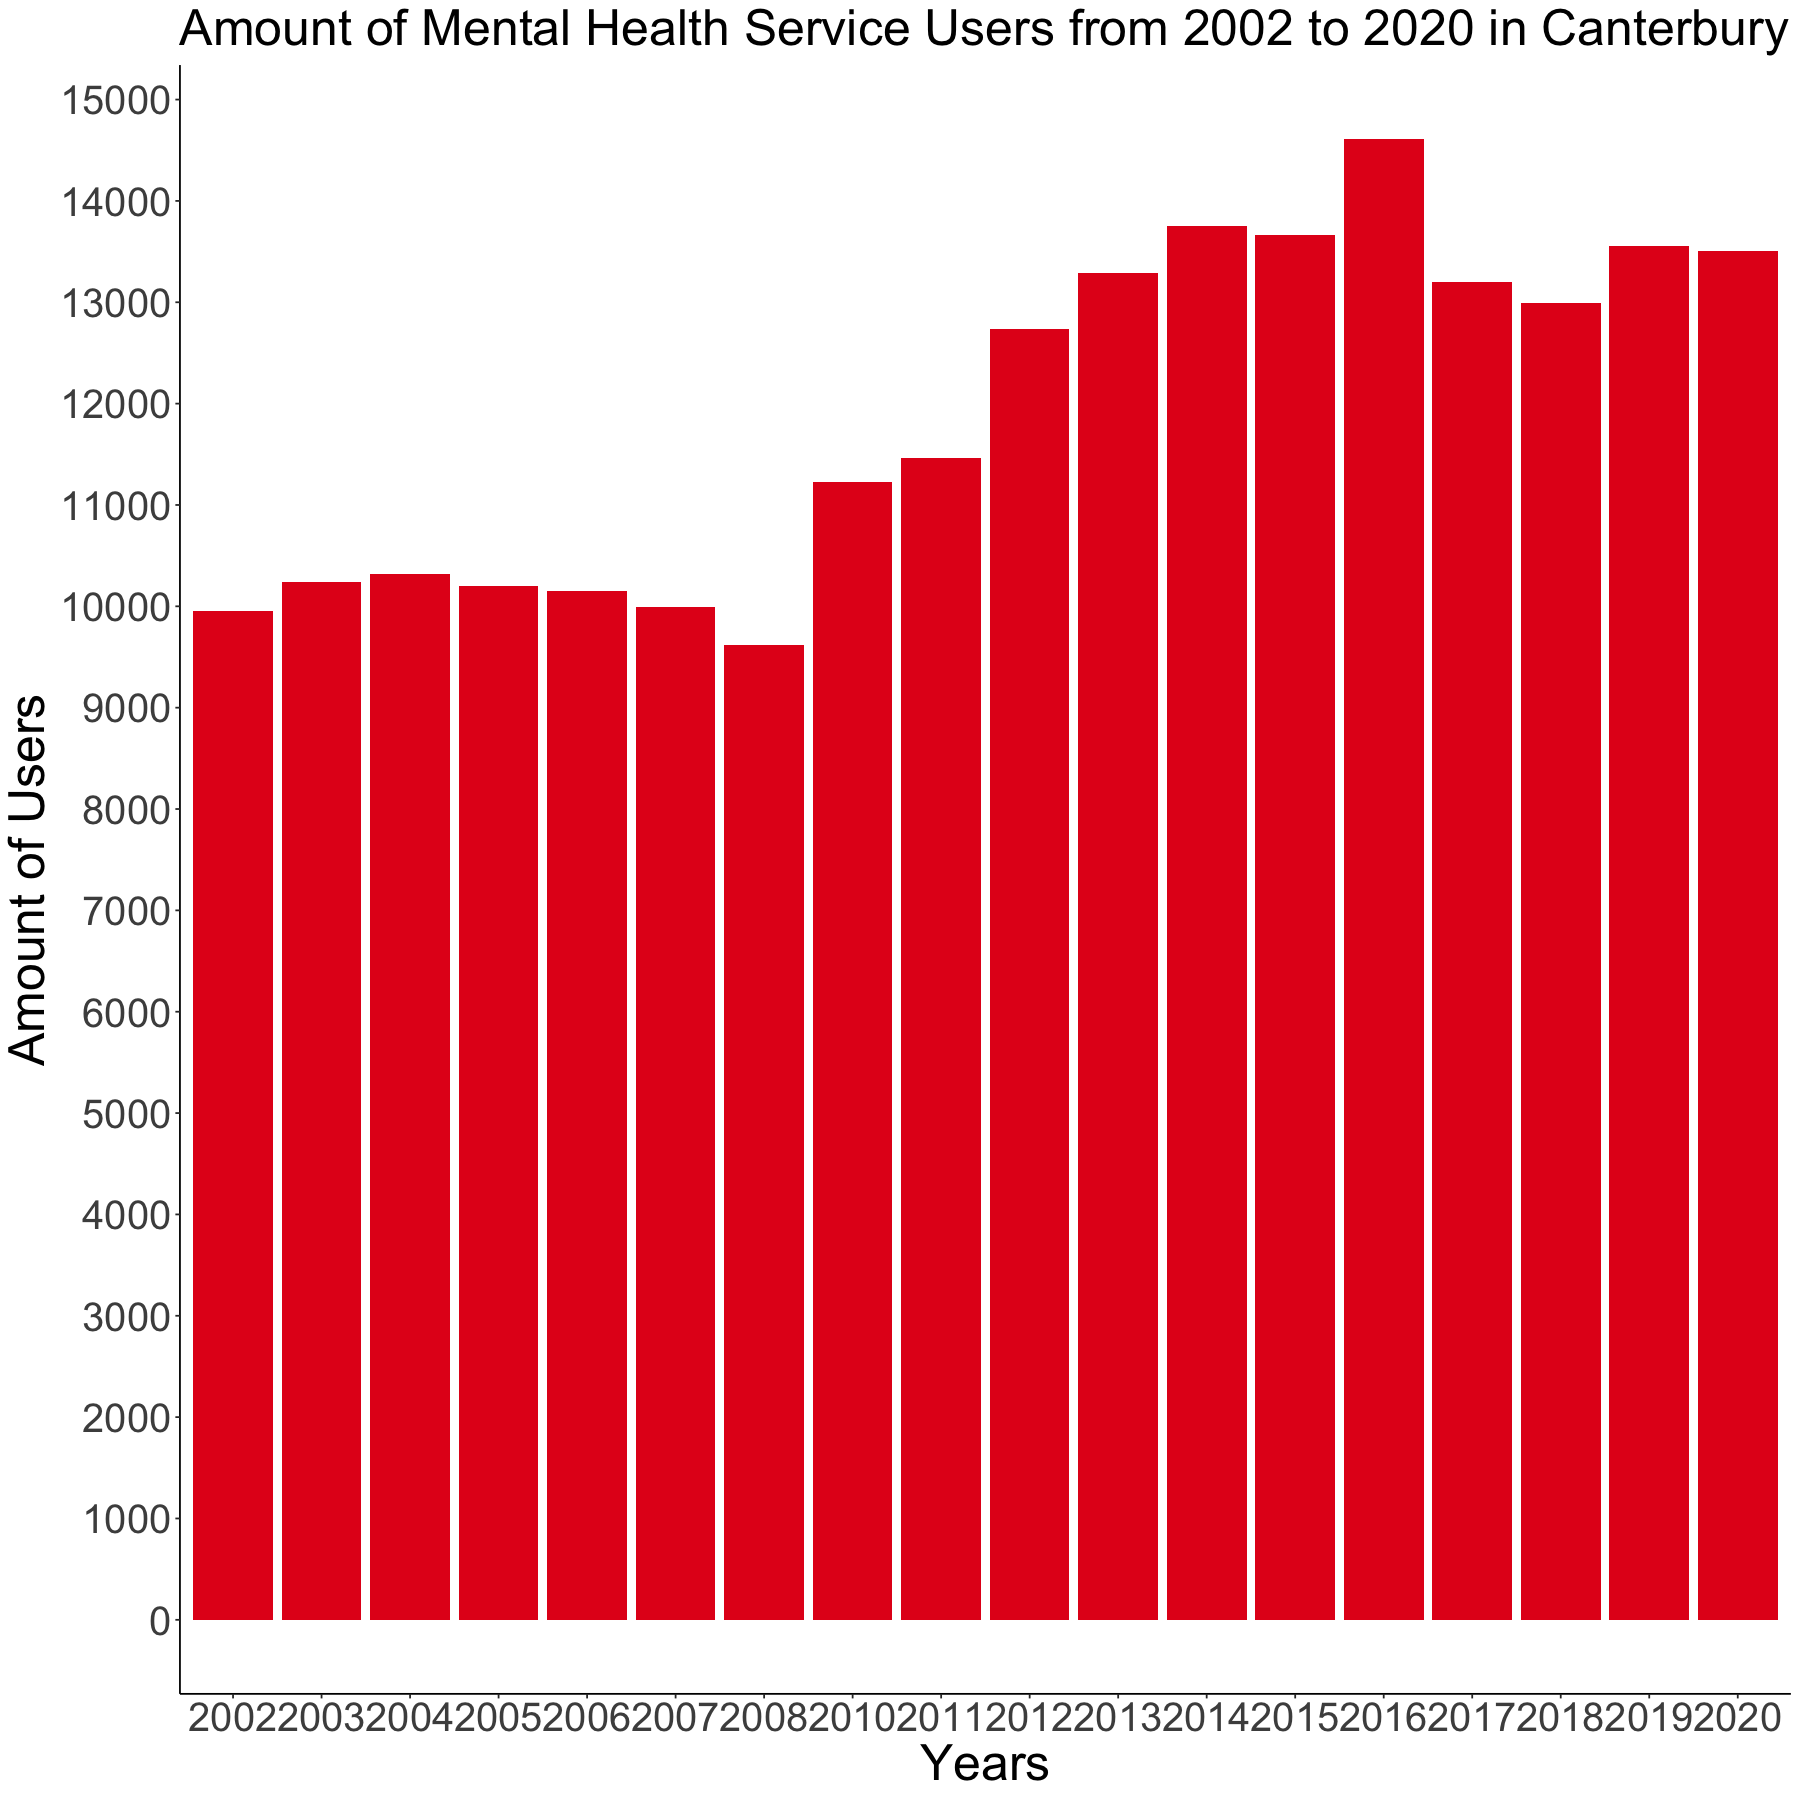

In [1473]:
longer_dhb_data %>% filter(destination!='Unknown', destination=='Canterbury')%>% 
                    group_by(destination, year) %>%
                    select(destination, year,  amount) %>% #filter(year==201) %>% summarise(tot=sum(amount))#%>% 
                    summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                    ggplot(aes(fill=destination, y=sum_amount, x=year)) + 
                    geom_bar(position="stack", stat="identity") + 
                    labs(x= "Years", 
                      y='Amount of Users',
                      fill='DHB',
                      title='Amount of Mental Health Service Users from 2002 to 2020 in Canterbury') +
                    theme_classic() + theme(plot.title = element_text(size=30),
                                          text = element_text(size=30))  +


                    scale_fill_brewer(palette="Set1") +  #assigning pallete
                    scale_y_continuous(breaks=seq(0, 20000, 1000))+ guides(fill=FALSE)


ggsave('canterbury.png', scale=3)

In [1506]:
get_service_data <- function(filename, sheet, range, year, cols=NULL){
   data <- filename %>% read_excel(sheet=sheet, range=range) 
   colnames(data)[1] <- 'activity'
   colnames(data)[2] <- 'gender'
   colnames(data)[3] <- 'Total'

   if (year == 2003){
       colnames(data)[4] <- '0-4'
   }
   colnames(data) <- gsub('-', '–', colnames(data)) # that took a long time.
   data <- data %>% mutate(activity = as.character(na_if(activity, '.'))) %>% 
             fill(activity, .direction = 'down') %>% 
             na.omit(gender) %>% 
             filter(gender!='Total') %>% 
             select(-Total) %>%
             mutate(year=year)
    
    if (!(missing(cols))){
        colnames(data) <- cols
    }
    return(data)
}

full_colnames <- colnames(get_service_data('mental_health2002.xls', "A9",  'B5:V131', 2002))


service_data <- get_service_data('mental_health2002.xls', "A15",  'B5:V93', 2002) %>%
                rbind(get_service_data('mental_health2003.xls', "A15",  'B5:V93', 2003)) %>% 
                rbind(get_service_data('mental_health2004.xls', "A15",  'B5:V93', 2004)) %>% 
                rbind(get_service_data('mental_health2005.xls', "A15",  'B5:V93', 2005)) %>% 
                rbind(get_service_data('mental_health2006.xls', "15A",  'B5:V93', 2006, full_colnames)) %>% 
                rbind(get_service_data('mental_health2007.xls', "15B",  'B5:V93', 2007, full_colnames)) %>% 
                rbind(get_service_data('mental_health2008.xls', "A15",  'B5:V93', 2008, full_colnames)) %>%
                rbind(get_service_data('mental_health2011.xlsx', "Table23",  'A4:U73', 2011, full_colnames)) %>%
                rbind(get_service_data('mental_health2012.xlsx', "table23",  'A4:U73', 2012, full_colnames)) %>%
                rbind(get_service_data('mental_health2013.xlsx', "table23",  'A4:U73', 2013, full_colnames)) %>% 
                rbind(get_service_data('mental_health2014.xlsx', "table23",  'A4:U73', 2014, full_colnames)) %>% 
                rbind(get_service_data('mental_health2015.xlsx', "table23",  'A4:U73', 2015, full_colnames)) %>% 
                rbind(get_service_data('mental_health2016.xlsx', "table23",  'A3:U43', 2016, full_colnames)) %>% 
                rbind(get_service_data('mental_health2017.xlsx', "table23",  'A4:U73', 2017, full_colnames)) %>%
                rbind(get_service_data('mental_health2018.xlsx', "table23",  'A4:U73', 2018, full_colnames)) %>%
                rbind(get_service_data('mental_health2019.xlsx', "table23",  'A4:U73', 2019, full_colnames)) %>% 
                rbind(get_service_data('mental_health2020.xlsx', "table23",  'A4:U73', 2020, full_colnames)) 



New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...5
* `` -> ...6
* `` -> ...7
* `` -> ...8
* `` -> ...9
* ...

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3



In [1507]:
long_col_name <- service_data %>% select(ends_with("-"), ends_with('+')) %>% names()
service_data <- service_data %>% pivot_longer(!c(activity, gender, year), names_to="age_group", values_to="amount")


In [1508]:
service_data <- service_data %>% filter(activity!='Total') %>% mutate(activity=tolower(activity))
service_data <- service_data %>% mutate(amount=as.integer(amount))


Saving 21 x 21 in image



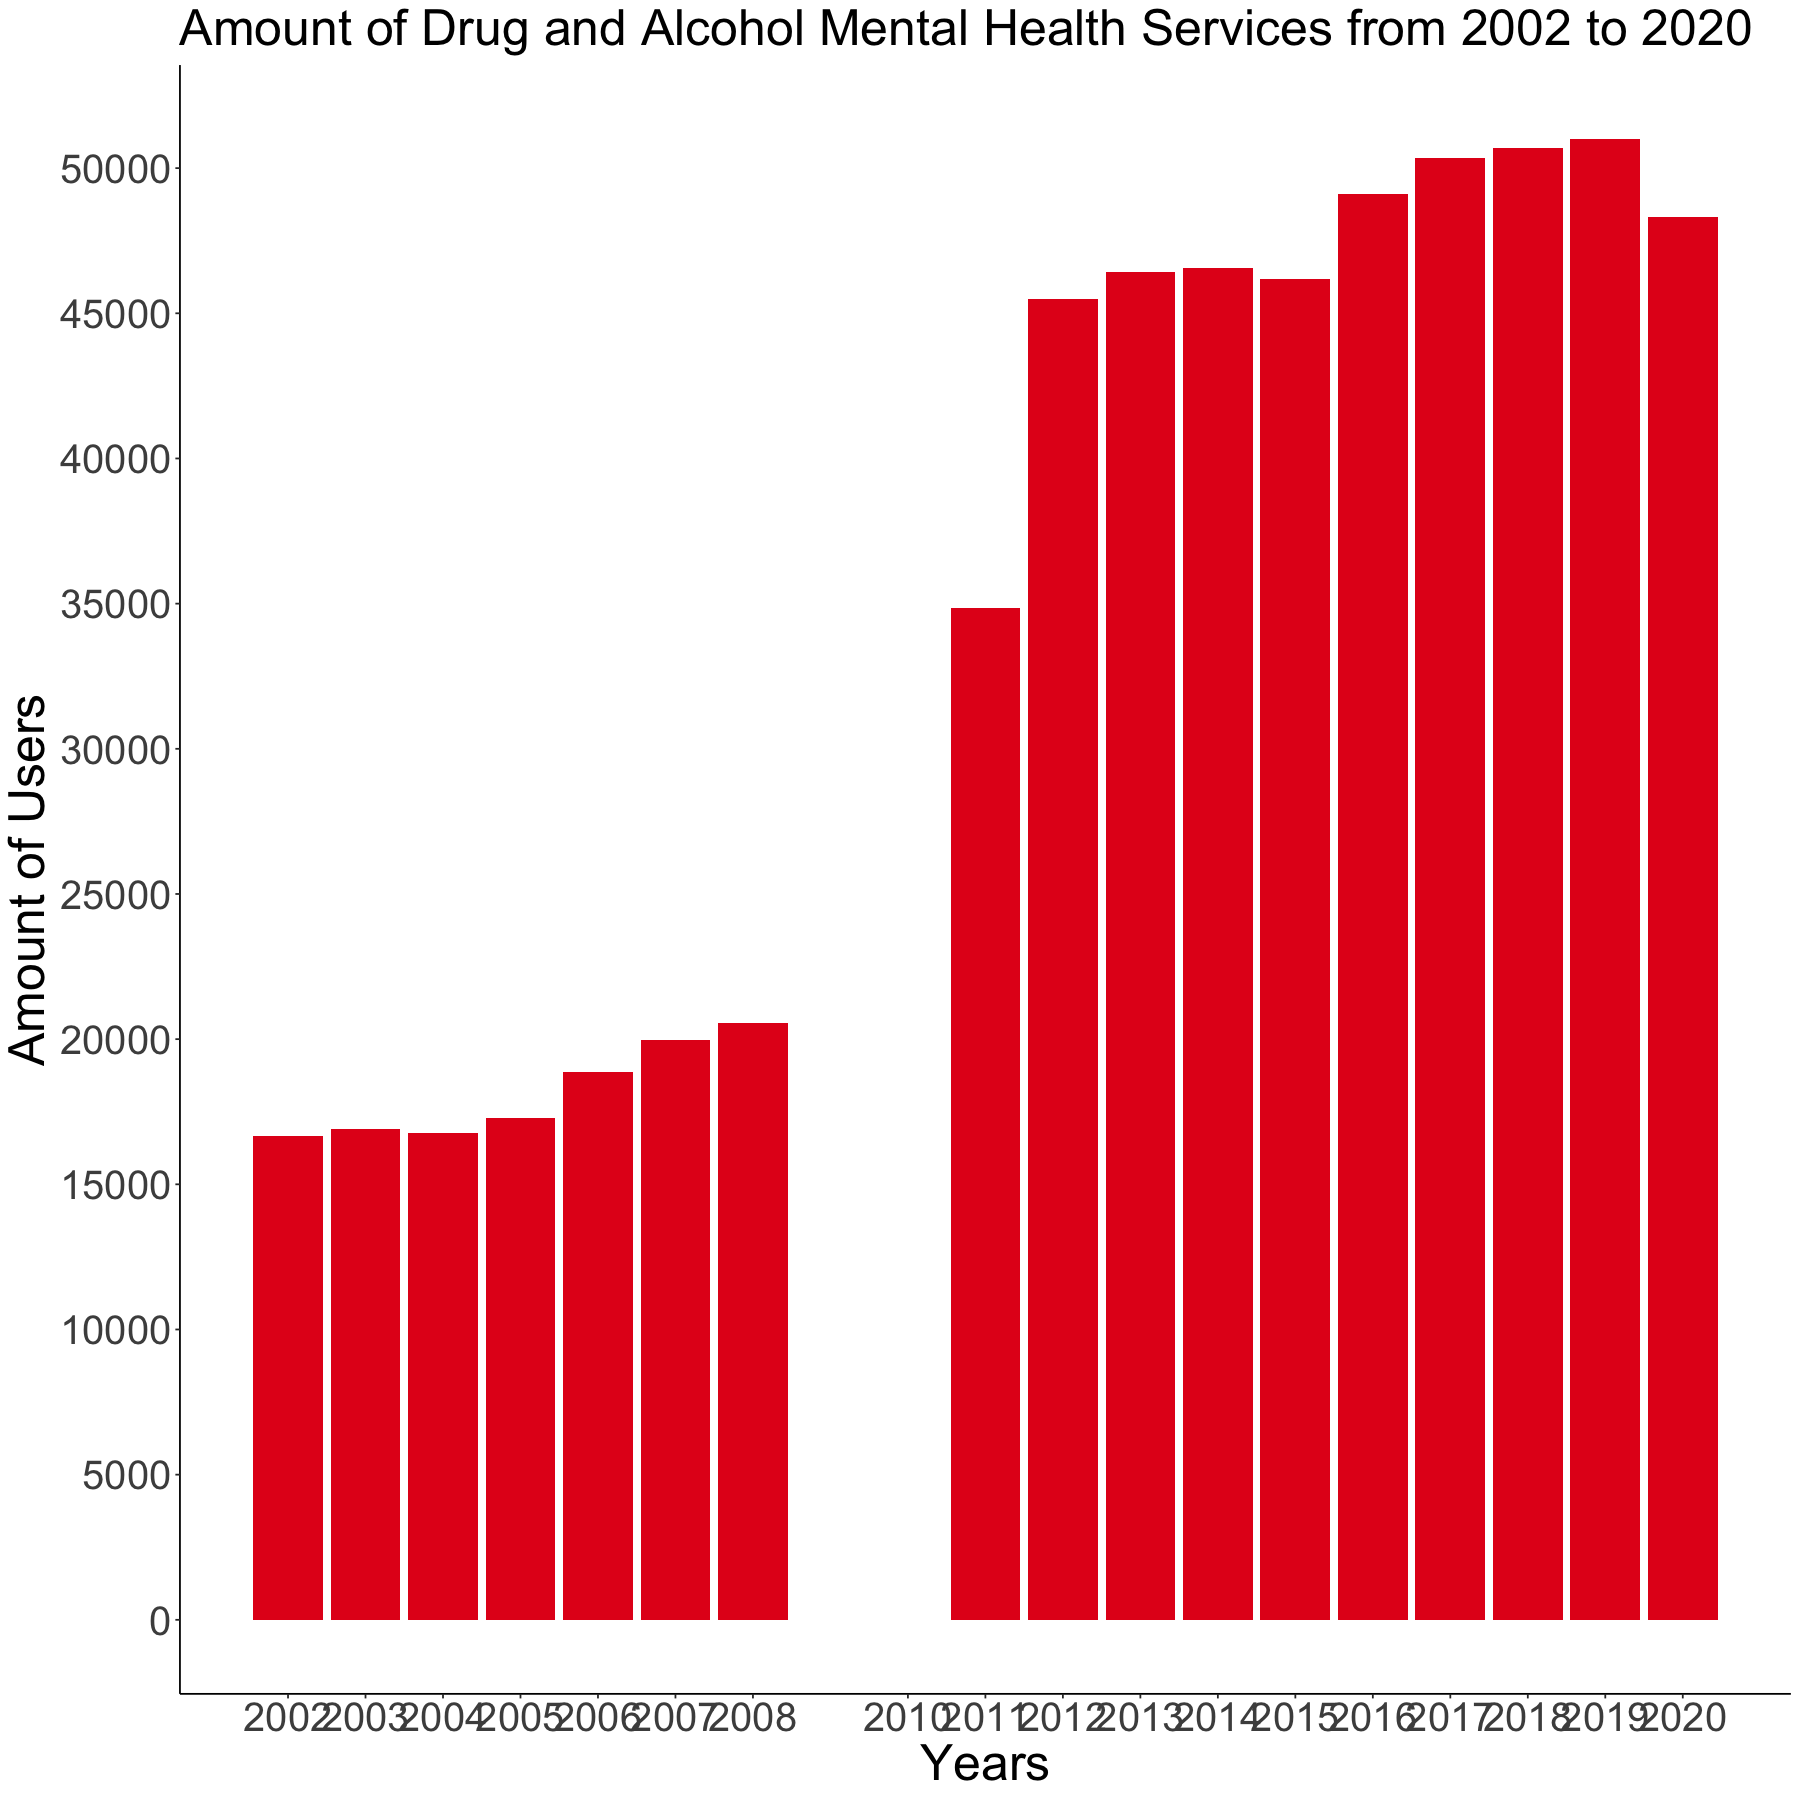

In [1516]:


service_data %>% filter(activity=='alcohol and drug team') %>%
                group_by(year, activity) %>% 
                select(year, activity, amount) %>%
                summarise(sum_amount = round(sum(amount)), .groups='drop_last') %>%  # getting the mean amount of users for each user type by hour (droping the last column)
                ggplot( aes(fill=activity, y=sum_amount, x=year)) + 
                geom_bar(position="stack", stat="identity") + 
                scale_x_continuous(breaks=years$year) + 
                labs(x= "Years", 
                     y='Amount of Users',
                     fill='Service',
                     title='Amount of Drug and Alcohol Mental Health Services from 2002 to 2020') +
                    theme_classic() + theme(plot.title = element_text(size=30),
                                          text = element_text(size=30))  +


                    scale_fill_brewer(palette="Set1") +  #assigning pallete
 
                scale_y_continuous(breaks=seq(0, 200000, 5000)) + guides(fill=FALSE)

ggsave('service.png', scale=3)
